In [1]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


# Machine learning and drift detection
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Statistical tests
from scipy.stats import ks_2samp, entropy
from scipy.spatial.distance import jensenshannon

# Datetime processing
from datetime import datetime

import re

# Utility
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# Load the CSV files
df_2024 = pd.read_csv("tc_2024_fullcol_clean.csv")
df_2025 = pd.read_csv("tc_2025_fullcol_clean.csv")  # update if needed
df_pre2024 = pd.read_csv("intake_pre2024_from_training.csv")

# Define restricted fields
restricted_fields = [
    "Transferring_Facility__r.Name",  # used consistently across all three files
    "Patient_Prospect__c", "Pertinent_History_Reason_Admitted__c",
    "Higher_Level_of_Care_Specifications__c", "Smart_Transfer__c",
    "Transfer_Type__c", "Required_Level_Of_Care__c", "Physician_Decision__c",
    "Patient_Status__c", "Insurance_Type__c",
    "Current_Condition__c", "Priority_Score__c", "Resource_Intensive_Red_Flags__c",
    "Current_Treatment__c", "Transplant_Status__c", "Infection_Precaution__c",
    "Infection_Precaution_Needed__c", "Infection_Precaution_Details__c"
]

# Add temporal column name per file
df_2024['admitdatetime'] = pd.to_datetime(df_2024['Date_Admitted_to_Trans_Facility__c'])
df_2025['admitdatetime'] = pd.to_datetime(df_2025['Date_Admitted_to_Trans_Facility__c'])
df_pre2024['admitdatetime'] = pd.to_datetime(df_pre2024['admitdatetime'])

# Select available restricted fields per file
def filter_restricted_fields(df):
    existing_cols = [col for col in restricted_fields if col in df.columns]
    return df[['admitdatetime'] + existing_cols]

df_2024_restricted = filter_restricted_fields(df_2024)
df_2025_restricted = filter_restricted_fields(df_2025)
df_pre2024_restricted = filter_restricted_fields(df_pre2024)

# Combine 2024 & 2025
df_2024_2025 = pd.concat([df_2024_restricted, df_2025_restricted], ignore_index=True)

# Combine all three
df_all_combined = pd.concat([df_2024_2025, df_pre2024_restricted], ignore_index=True)

# Print shapes to confirm
print("✅ 2024–2025 restricted DF shape:", df_2024_2025.shape)
print("✅ All combined DF shape:", df_all_combined.shape)

✅ 2024–2025 restricted DF shape: (11629, 14)
✅ All combined DF shape: (18873, 14)


In [3]:
def process_df_for_drift(df, cat_cardinality_thresh=50, min_records_per_month=100):
    """
    Process a patient transfer DataFrame for drift analysis.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        cat_cardinality_thresh (int): Threshold for classifying categorical vs text columns.
        min_records_per_month (int): Minimum number of records to keep a month.

    Returns:
        df_time_filtered (pd.DataFrame): Cleaned and filtered DataFrame.
        column_summary (dict): Summary of column types.
        missing_report (pd.DataFrame): Report of missing data.
    """
    
    print(f"Initial shape: Rows={df.shape[0]}, Columns={df.shape[1]}")
    
    # --- Step 1: Missing values report ---
    missing_counts = df.isna().sum()
    missing_percent = df.isna().mean() * 100
    missing_report = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_percent
    })
    missing_report = missing_report[missing_report['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

    print("\nColumns with missing values:")
    print(missing_report)
    
    # --- Step 2: Parse datetime ---
    if 'admitdatetime' in df.columns:
        df['admitdatetime'] = pd.to_datetime(df['admitdatetime'], errors='coerce')
    else:
        raise ValueError("Expected 'admitdatetime' column not found in DataFrame.")
    
    # --- Step 3: Column type summary ---
    def summarize_column_types(df, cat_cardinality_thresh):
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        categorical_cols = []
        text_cols = []

        for col in object_cols:
            unique_vals = df[col].nunique(dropna=True)
            if unique_vals < cat_cardinality_thresh:
                categorical_cols.append(col)
            else:
                text_cols.append(col)

        datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
        return {
            'Numeric columns': numeric_cols,
            'Categorical columns': categorical_cols,
            'Text (free-form) columns': text_cols,
            'Datetime columns': datetime_cols
        }

    column_summary = summarize_column_types(df, cat_cardinality_thresh)
    print("\nColumn type summary:")
    for k, v in column_summary.items():
        print(f"{k} ({len(v)}): {v}\n")

    # --- Step 4: Filter for valid dates and valid months ---
    df_time_filtered = df[df['admitdatetime'].notna()].copy()
    df_time_filtered['month'] = df_time_filtered['admitdatetime'].dt.to_period('M')

    monthly_counts = df_time_filtered['month'].value_counts()
    valid_months = monthly_counts[monthly_counts >= min_records_per_month].index
    df_time_filtered = df_time_filtered[df_time_filtered['month'].isin(valid_months)]

    # --- Step 5: Drop ID-like columns if present ---
    columns_to_drop = [
        'CaseNumber', 'MRN__c', 'FIN__c', 'Id',
        'Patient_Name_Formula__c', 'Patient_Zip_Code__c',
        'At_Risk_Party__c', 'AppointmentDate__c'
    ]
    df_time_filtered.drop(columns=[col for col in columns_to_drop if col in df_time_filtered.columns], inplace=True)

    # --- Step 6: Sort by date ---
    df_time_filtered = df_time_filtered.sort_values(by='admitdatetime')

    # --- Final report ---
    print("Valid monthly record counts after filtering:")
    print(df_time_filtered['month'].value_counts().sort_index())

    return df_time_filtered, column_summary, missing_report

In [4]:
df_cleaned_2024_2025, summary_2024_2025, missing_2024_2025 = process_df_for_drift(df_2024_2025)
df_cleaned_combined, summary_combined, missing_combined = process_df_for_drift(df_all_combined)

Initial shape: Rows=11629, Columns=14

Columns with missing values:
                                      Missing Count  Missing %
Resource_Intensive_Red_Flags__c               11382  97.876000
admitdatetime                                  8826  75.896466
Smart_Transfer__c                              7011  60.288933
Physician_Decision__c                          5089  43.761286
Priority_Score__c                              3029  26.046952
Insurance_Type__c                              2522  21.687161
Current_Condition__c                            909   7.816665
Pertinent_History_Reason_Admitted__c            270   2.321782
Required_Level_Of_Care__c                        38   0.326769
Transferring_Facility__r.Name                    13   0.111789
Patient_Status__c                                 4   0.034397

Column type summary:
Numeric columns (1): ['Priority_Score__c']

Categorical columns (8): ['Patient_Prospect__c', 'Smart_Transfer__c', 'Transfer_Type__c', 'Required_Level_Of_C

In [5]:
df_cleaned_2024_2025=df_cleaned_2024_2025.drop(columns=['month','Transferring_Facility__r.Name'])
df_cleaned_combined=df_cleaned_combined.drop(columns=['month','Transferring_Facility__r.Name'])

In [6]:
df_all_combined.columns

Index(['admitdatetime', 'Transferring_Facility__r.Name', 'Patient_Prospect__c',
       'Pertinent_History_Reason_Admitted__c',
       'Higher_Level_of_Care_Specifications__c', 'Smart_Transfer__c',
       'Transfer_Type__c', 'Required_Level_Of_Care__c',
       'Physician_Decision__c', 'Patient_Status__c', 'Insurance_Type__c',
       'Current_Condition__c', 'Priority_Score__c',
       'Resource_Intensive_Red_Flags__c'],
      dtype='object')

In [7]:
df_cleaned_combined.columns

Index(['admitdatetime', 'Patient_Prospect__c',
       'Pertinent_History_Reason_Admitted__c',
       'Higher_Level_of_Care_Specifications__c', 'Smart_Transfer__c',
       'Transfer_Type__c', 'Required_Level_Of_Care__c',
       'Physician_Decision__c', 'Patient_Status__c', 'Insurance_Type__c',
       'Current_Condition__c', 'Priority_Score__c',
       'Resource_Intensive_Red_Flags__c'],
      dtype='object')

In [8]:
# Assuming df_cleaned_combined is your drift metrics DataFrame
print("=== Drift Metrics Data Date Range ===")
print(f"From: {df_cleaned_combined['admitdatetime'].min()}")
print(f"To:   {df_cleaned_combined['admitdatetime'].max()}")
print(f"Total records: {len(df_cleaned_combined)}")

=== Drift Metrics Data Date Range ===
From: 2020-05-01 10:44:00
To:   2025-03-31 00:00:00
Total records: 9841


# Feature importance and data sanity check

In [9]:
def extract_text_features(texts):
    features = []
    for text in texts:
        if not isinstance(text, str):
            text = ''
        text_features = [
            len(text),
            len(text.split()),
            len(re.findall(r'\d+', text)),
            len(re.findall(r'[A-Z]', text)),
            len(re.findall(r'[a-z]', text)),
            len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', text)),
            text.count('.'), text.count(','), text.count(';'), text.count(':'),
            text.count('('), text.count(')'), text.count('['), text.count(']'),
            text.count('{'), text.count('}'), text.count('"'), text.count("'"),
        ]
        features.append(text_features)
    return np.array(features)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from matplotlib.dates import MonthLocator, DateFormatter



def detect_outliers_fixed_training(df, time_col='admitdatetime', cat_thresh=50,
                                   training_start_months=12, rolling_window=4,
                                   baseline_window_months=3, contamination=0.1):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df[df[time_col].notna()].copy()
    df['week'] = df[time_col].dt.to_period('W').apply(lambda r: r.start_time)
    df['month'] = df[time_col].dt.to_period('M').apply(lambda r: r.start_time)

    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    text_cols = []
    categorical_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique(dropna=True) < cat_thresh:
            categorical_cols.append(col)
        else:
            text_cols.append(col)

    df = df.drop(columns=['outlier_flag'], errors='ignore')

    numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
    categorical_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        FunctionTransformer(lambda x: x.astype(str), validate=False),
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ], remainder='drop')

    X_structured = preprocessor.fit_transform(df[numeric_cols + categorical_cols])
    X_text = np.hstack([extract_text_features(df[col].fillna('')) for col in text_cols]) if text_cols else np.empty((len(df), 0))
    X_all = np.hstack([X_structured, X_text])

    df['outlier_flag'] = 0
    weeks = sorted(df['week'].unique())
    weeks_per_month = 4
    training_end_index = training_start_months * weeks_per_month

    if training_end_index >= len(weeks):
        raise ValueError("Training window exceeds available data range.")

    # Define train and test index
    train_weeks = weeks[:training_end_index]
    test_weeks = weeks[training_end_index:]

    train_idx = df['week'].isin(train_weeks)
    test_idx = df['week'].isin(test_weeks)

    X_train = X_all[train_idx]
    X_test = X_all[test_idx]

    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X_train)

    preds = model.predict(X_test)
    df.loc[test_idx, 'outlier_flag'] = (preds == -1).astype(int)

    # Weekly stats and rolling 4-week ratio
    weekly_stats = df.groupby('week')['outlier_flag'].agg(['sum', 'count']).reset_index()
    weekly_stats['ratio'] = weekly_stats['sum'] / weekly_stats['count']

    rolling_data = []
    for i in range(len(weekly_stats) - rolling_window + 1):
        window_df = weekly_stats.iloc[i:i + rolling_window]
        avg_ratio = window_df['ratio'].mean()
        rolling_data.append({
            'start_week': window_df['week'].iloc[0],
            'end_week': window_df['week'].iloc[-1],
            '4wk_avg_ratio': avg_ratio
        })
    rolling_df = pd.DataFrame(rolling_data)

    # Rolling baseline from previous n months
    baseline_weeks = baseline_window_months * weeks_per_month
    baseline_mean = rolling_df['4wk_avg_ratio'].rolling(window=baseline_weeks, min_periods=1).mean()
    baseline_std = rolling_df['4wk_avg_ratio'].rolling(window=baseline_weeks, min_periods=1).std()

    # Plot
    # Plot (starting only from prediction start week)
    prediction_start_week = weeks[training_end_index]
    rolling_df_plot = rolling_df[rolling_df['start_week'] >= prediction_start_week]
    baseline_mean_plot = baseline_mean[rolling_df_plot.index]
    baseline_std_plot = baseline_std[rolling_df_plot.index]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(rolling_df_plot['start_week'], rolling_df_plot['4wk_avg_ratio'],
            label='4-Week Avg Outlier Ratio', color='steelblue')
    ax.plot(rolling_df_plot['start_week'], baseline_mean_plot,
            label='Rolling Baseline Mean', linestyle='--', color='darkorange')
    ax.fill_between(rolling_df_plot['start_week'],
                    baseline_mean_plot - baseline_std_plot,
                    baseline_mean_plot + baseline_std_plot,
                    color='gray', alpha=0.3, label='Baseline ±1 std')


    ax.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right')

    ax.set_ylabel("Outlier Ratio")
    ax.set_title(f"Rolling Outlier Ratio (4-Week Average)\nwith Fixed Training Window ({training_start_months} Months)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return df, rolling_df

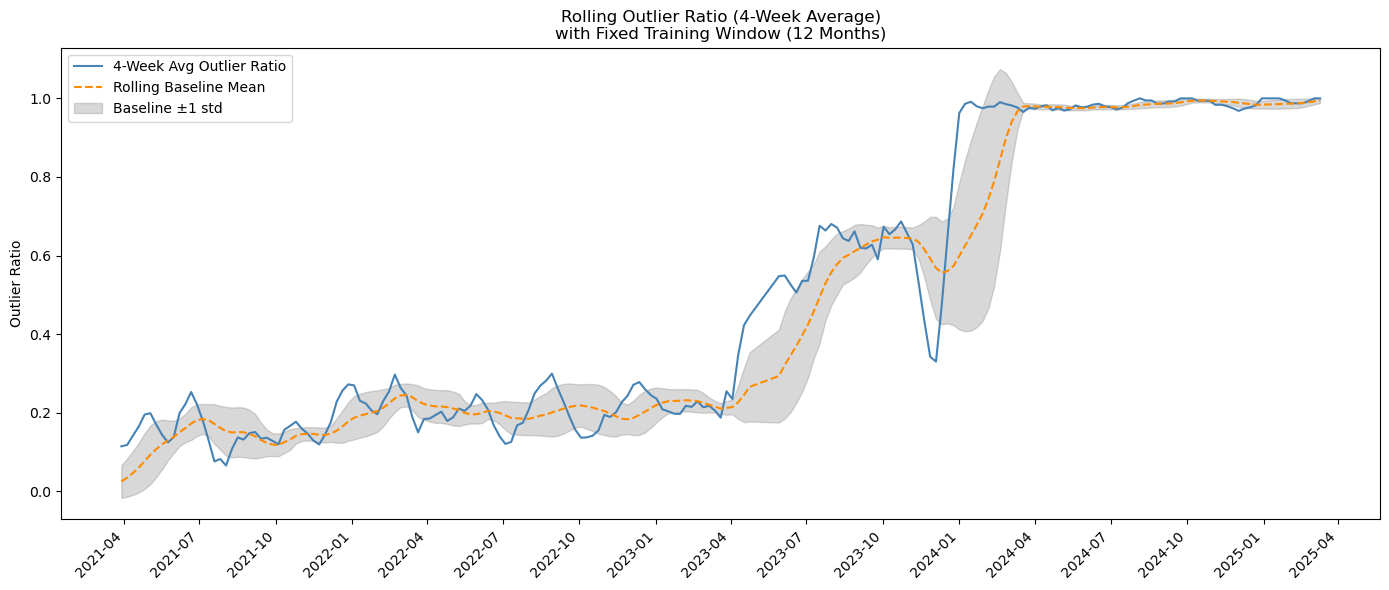

In [58]:
# Run the outlier detection with a fixed training window of 12 months (1 year)
df_outliers, rolling_df = detect_outliers_fixed_training(
    df=df_cleaned_combined,
    time_col='admitdatetime',         # Make sure this column exists and is datetime-compatible
    cat_thresh=50,                    # Threshold for separating categorical vs text
    training_start_months=12,         # Use first 12 months for training
    rolling_window=4,                 # 4-week rolling average for outlier ratio
    baseline_window_months=3,         # 3-month rolling baseline for plotting
    contamination=0.1                 # Isolation Forest contamination level
)


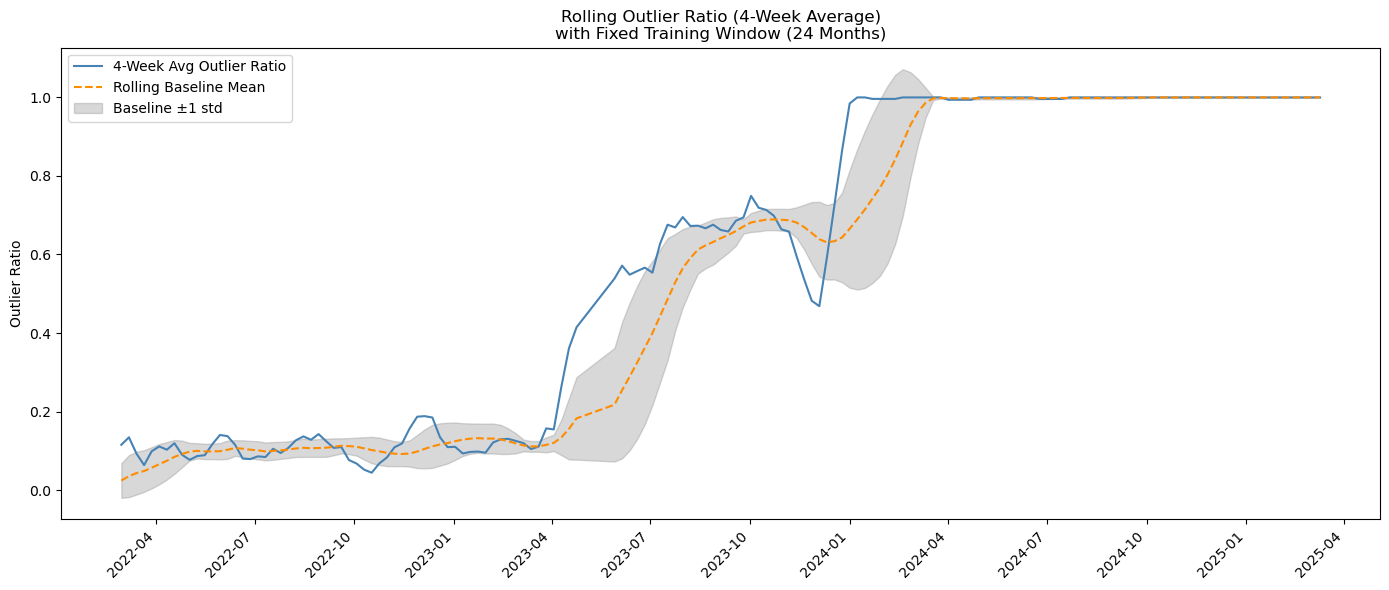

In [59]:
# Run the outlier detection with a fixed training window of 24 months (2 year)
df_outliers, rolling_df = detect_outliers_fixed_training(
    df=df_cleaned_combined,
    time_col='admitdatetime',         # Make sure this column exists and is datetime-compatible
    cat_thresh=50,                    # Threshold for separating categorical vs text
    training_start_months=24,         # Use first 24 months for training
    rolling_window=4,                 # 4-week rolling average for outlier ratio
    baseline_window_months=3,         # 3-month rolling baseline for plotting
    contamination=0.1                 # Isolation Forest contamination level
)


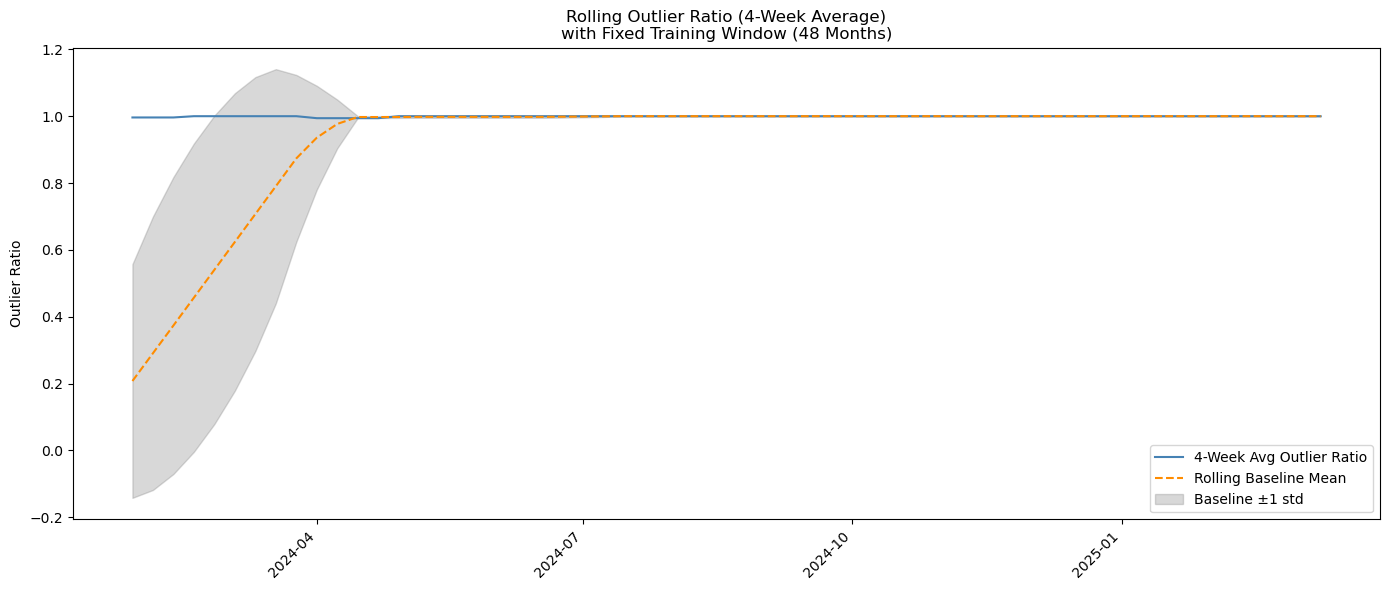

In [60]:
# Run the outlier detection with a fixed training window of 48 months (4 year)
df_outliers, rolling_df = detect_outliers_fixed_training(
    df=df_cleaned_combined,
    time_col='admitdatetime',         # Make sure this column exists and is datetime-compatible
    cat_thresh=50,                    # Threshold for separating categorical vs text
    training_start_months=48,         # Use first 24 months for training
    rolling_window=4,                 # 4-week rolling average for outlier ratio
    baseline_window_months=3,         # 3-month rolling baseline for plotting
    contamination=0.1                 # Isolation Forest contamination level
)

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def extract_text_metrics(text_series):
    """Return dataframe of numeric text metrics (length, word count, digits, punctuation)."""
    return pd.DataFrame({
        f"{text_series.name}_length": text_series.fillna('').apply(len),
        f"{text_series.name}_wordcount": text_series.fillna('').apply(lambda x: len(str(x).split())),
        f"{text_series.name}_num_digits": text_series.fillna('').apply(lambda x: len(re.findall(r'\d+', str(x)))),
        f"{text_series.name}_num_punct": text_series.fillna('').apply(lambda x: len(re.findall(r'[!@#$%^&*(),.?\":{}|<>]', str(x))))
    })

def plot_features_monthly(df, time_col='admitdatetime', cat_thresh=50):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df['month'] = df[time_col].dt.to_period('M').astype(str)

    # Separate features
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != time_col]

    categorical_cols, text_cols = [], []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique(dropna=True) < cat_thresh:
            categorical_cols.append(col)
        else:
            text_cols.append(col)

    # --- Numeric: monthly boxplot ---
    for col in numeric_cols:
        plt.figure(figsize=(12, 5))
        sns.boxplot(x='month', y=col, data=df)
        plt.title(f"Monthly Boxplot (Numeric): {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # --- Categorical: monthly stacked bar ---
    for col in categorical_cols:
        cat_month_counts = df.groupby(['month', col]).size().reset_index(name='count')
        cat_pivot = cat_month_counts.pivot(index='month', columns=col, values='count').fillna(0)
        cat_pivot.plot(kind='bar', stacked=True, figsize=(12, 5))
        plt.title(f"Monthly Category Distribution: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # --- Text: monthly boxplot of metrics ---
    for col in text_cols:
        text_df = extract_text_metrics(df[col])
        text_df['month'] = df['month']
        for metric in text_df.columns:
            if metric != 'month':
                plt.figure(figsize=(12, 5))
                sns.boxplot(x='month', y=metric, data=text_df)
                plt.title(f"Monthly Boxplot (Text Metric): {metric}")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

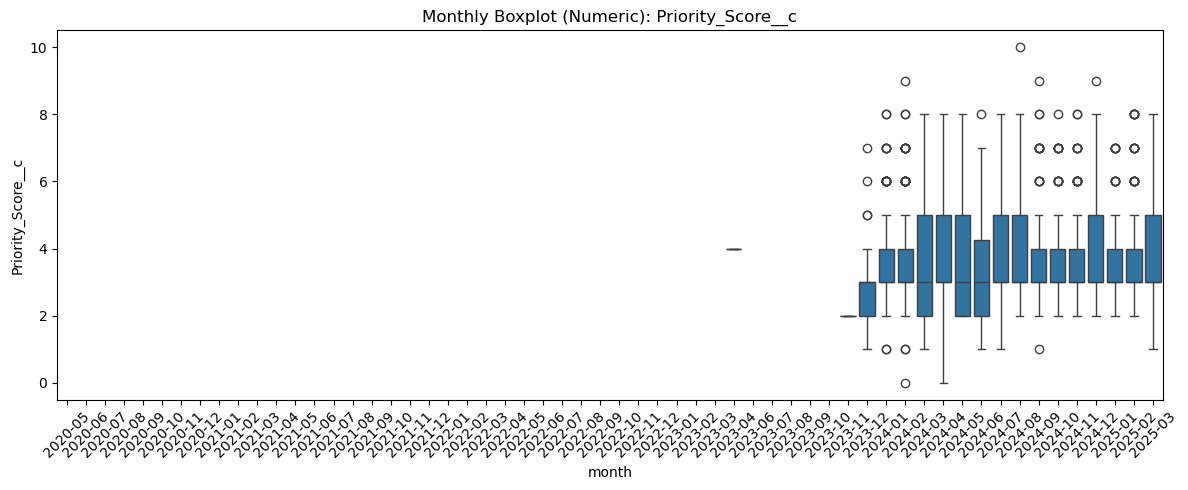

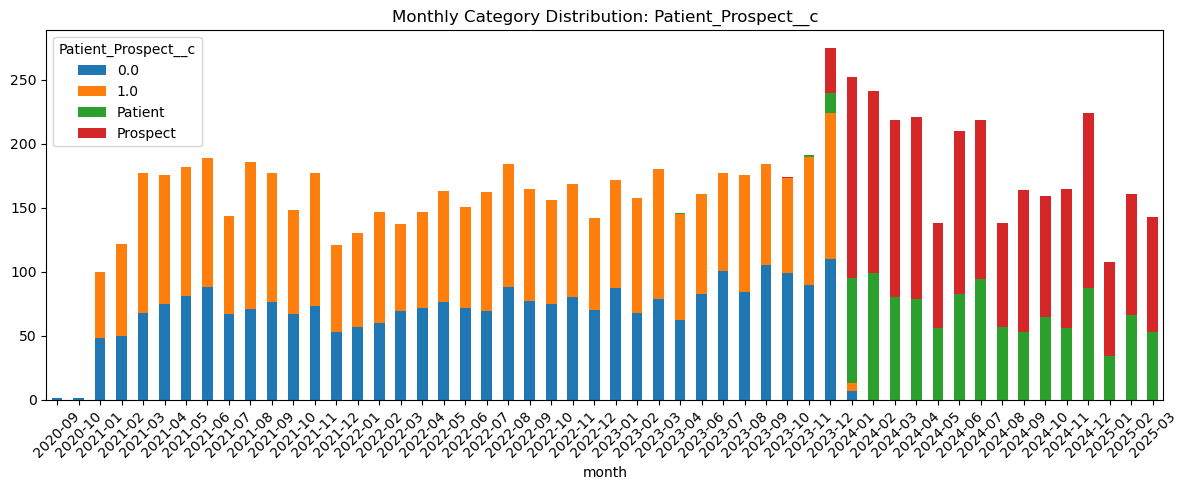

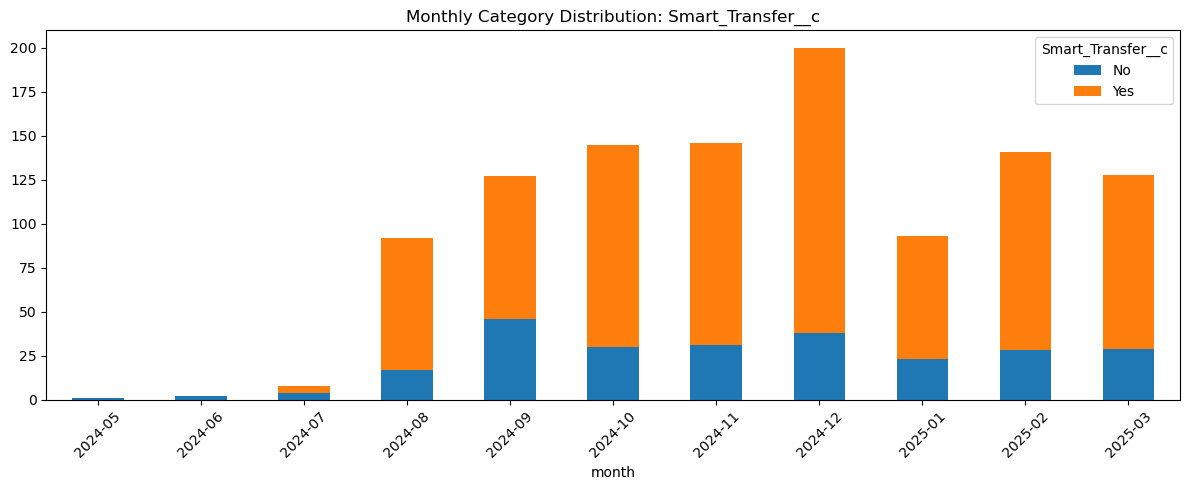

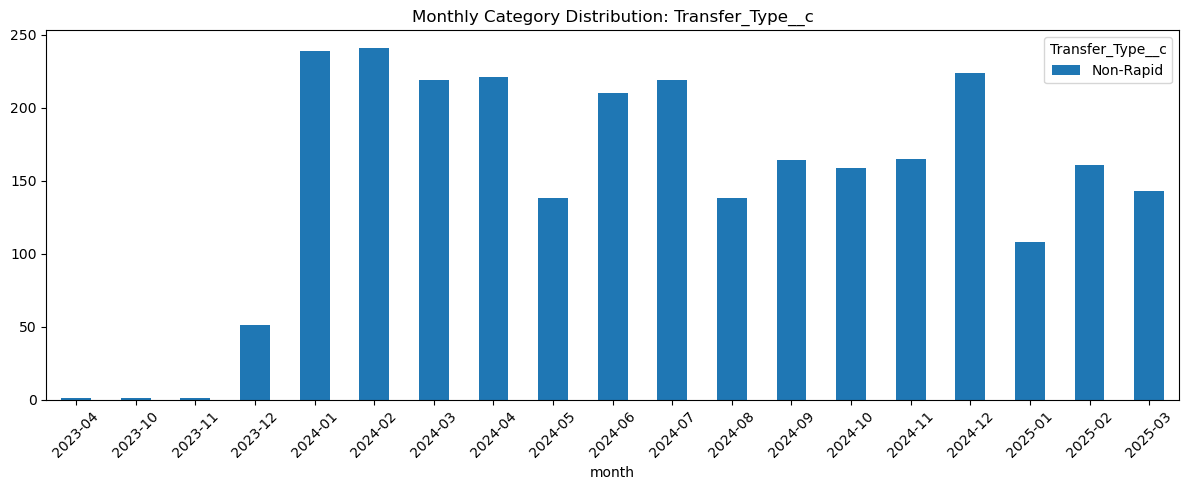

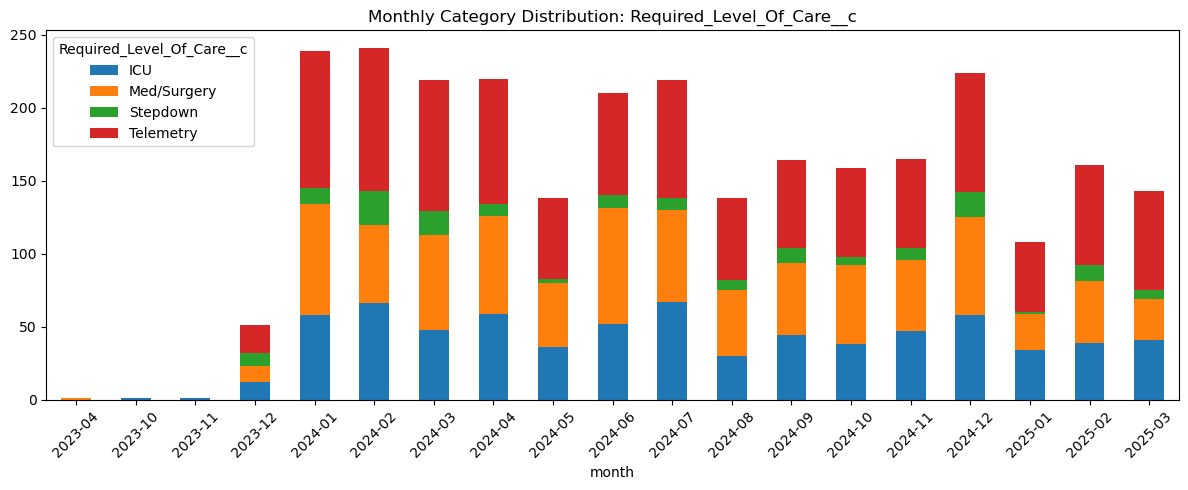

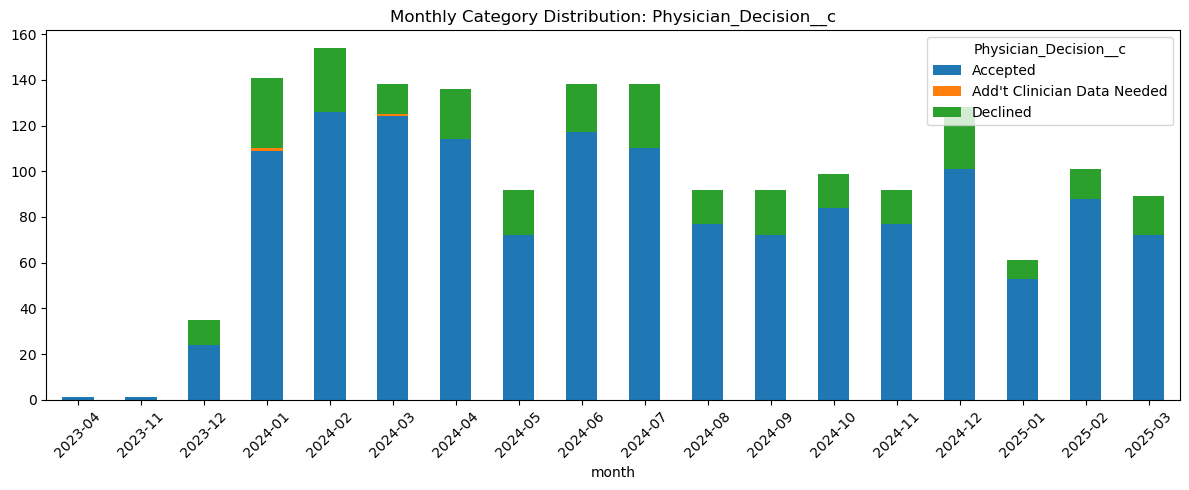

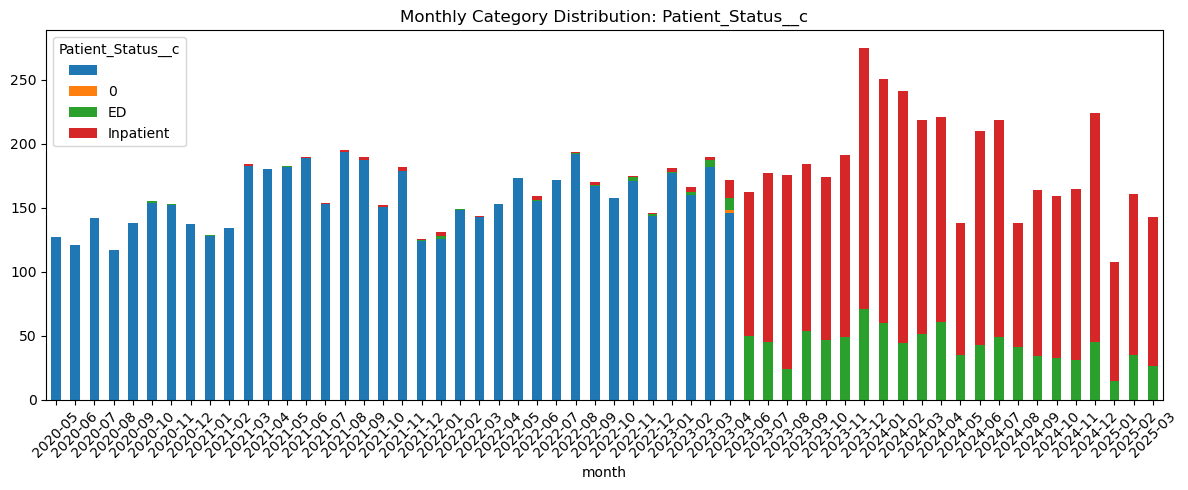

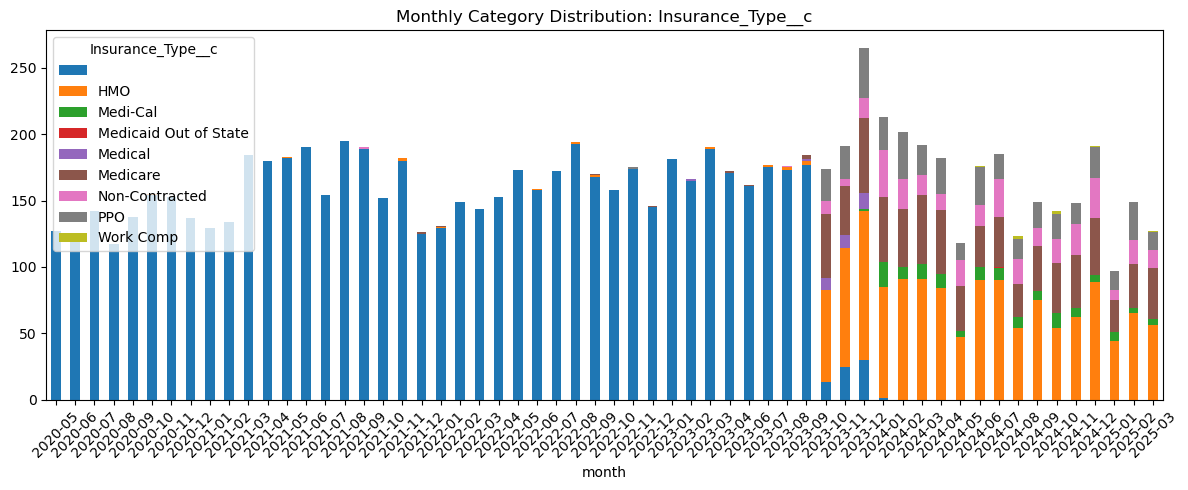

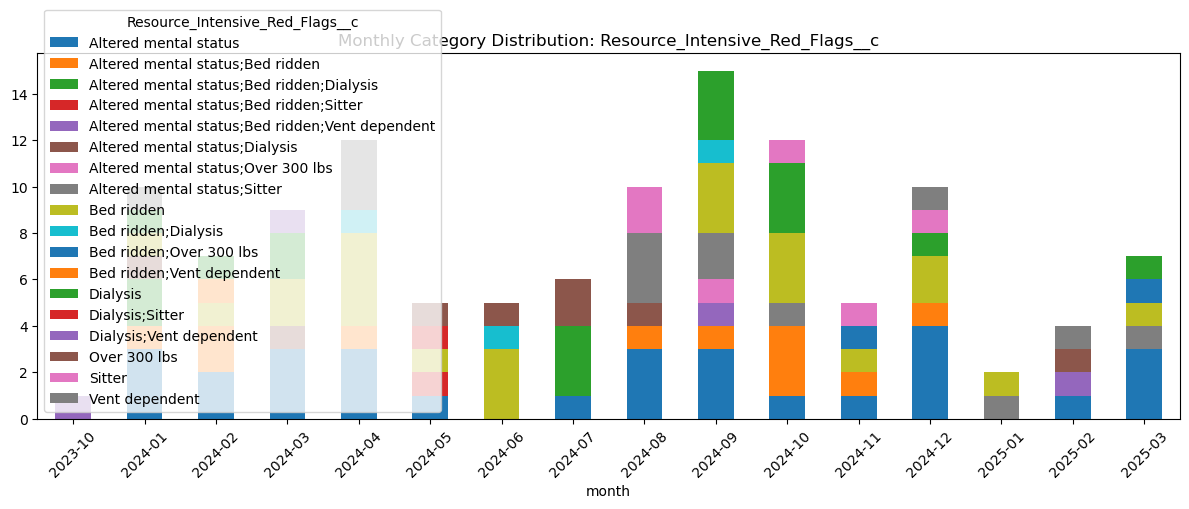

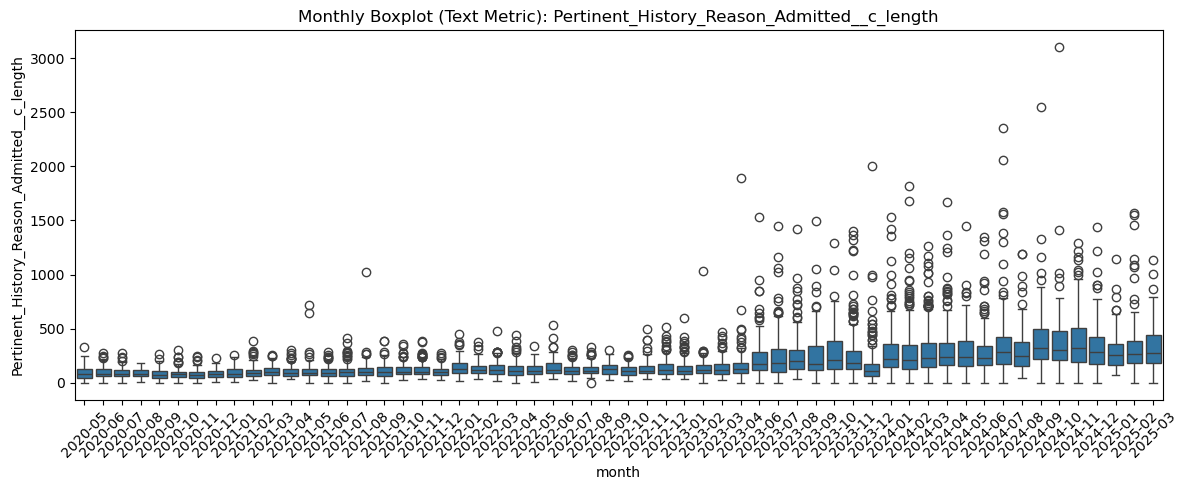

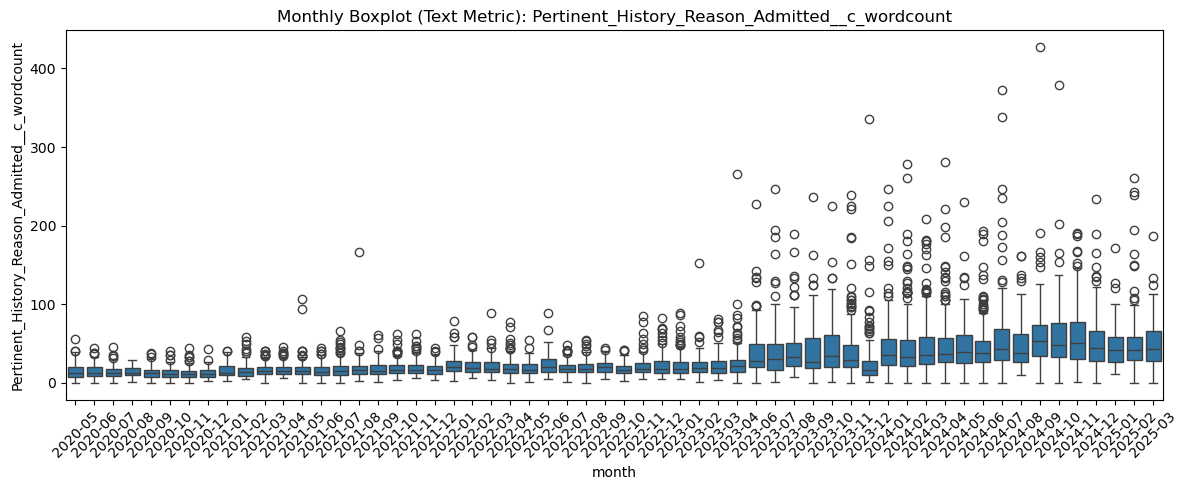

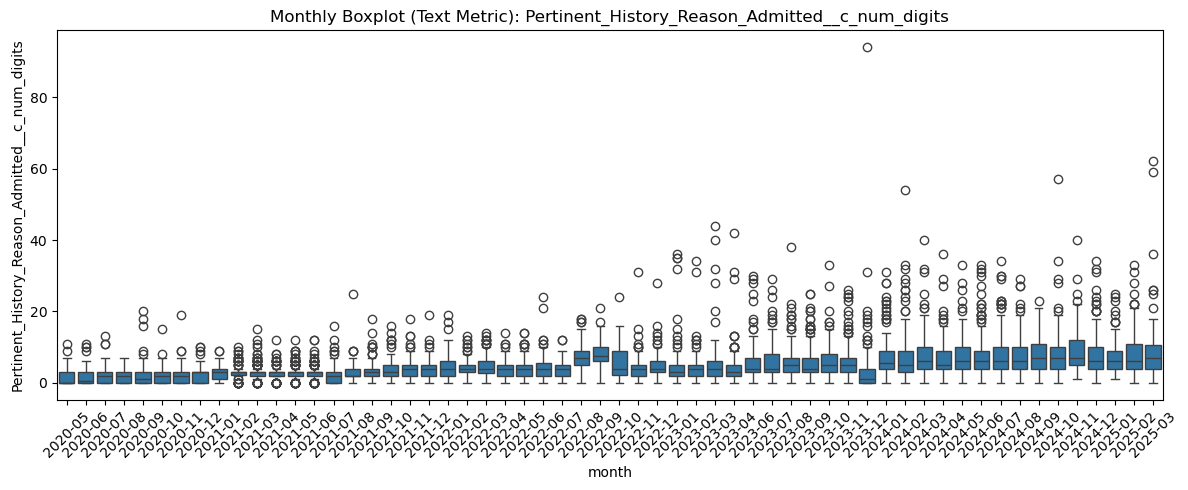

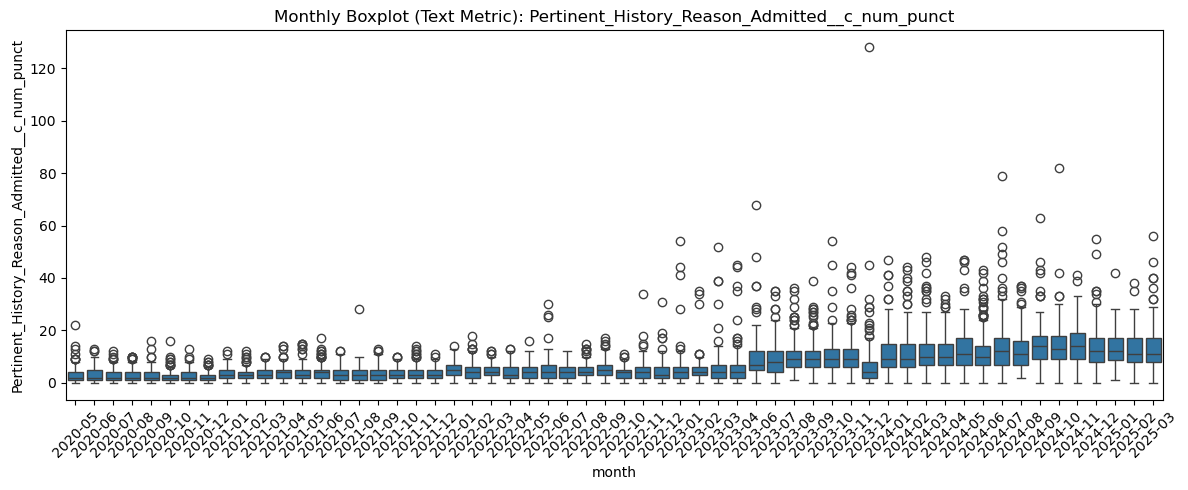

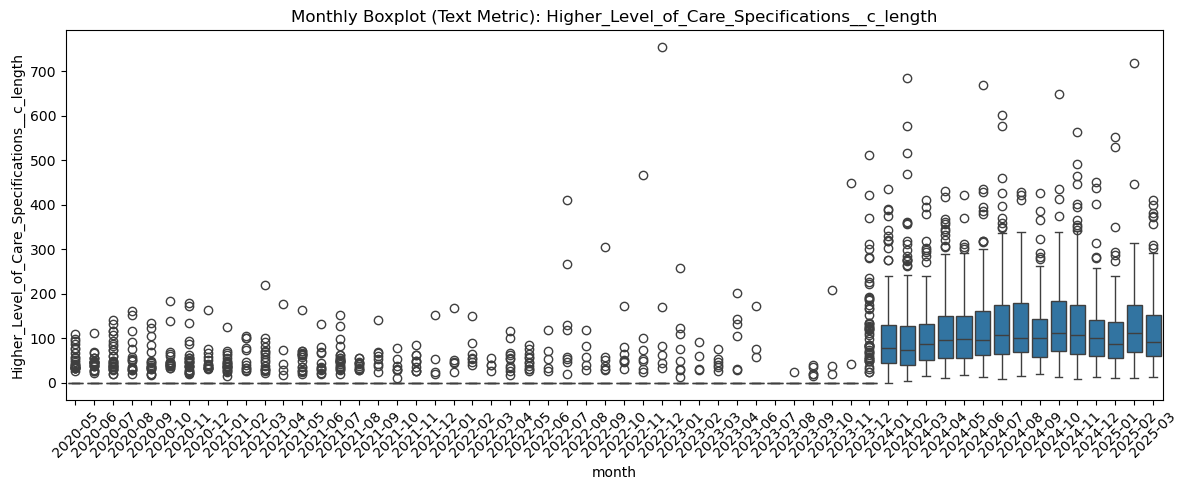

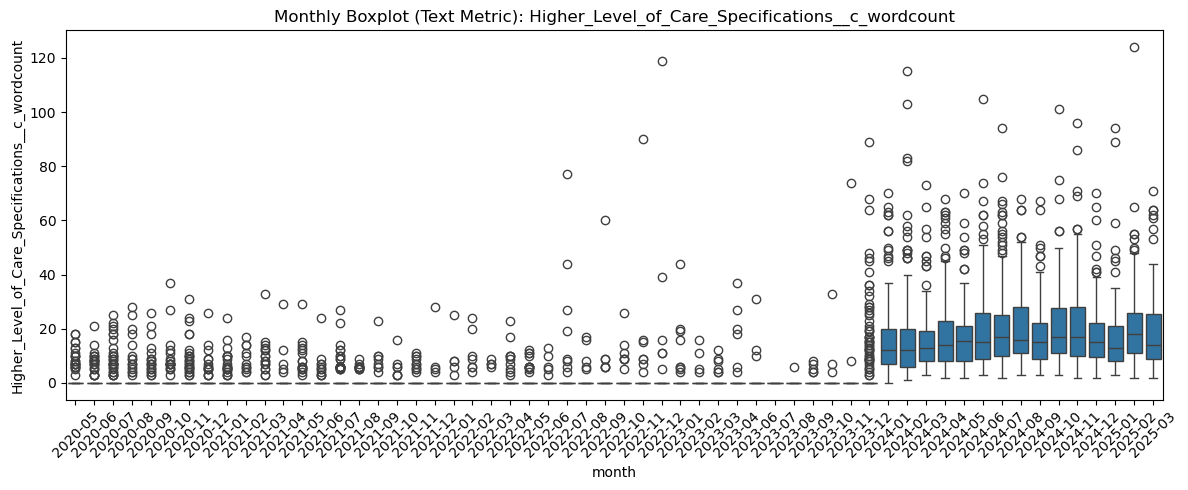

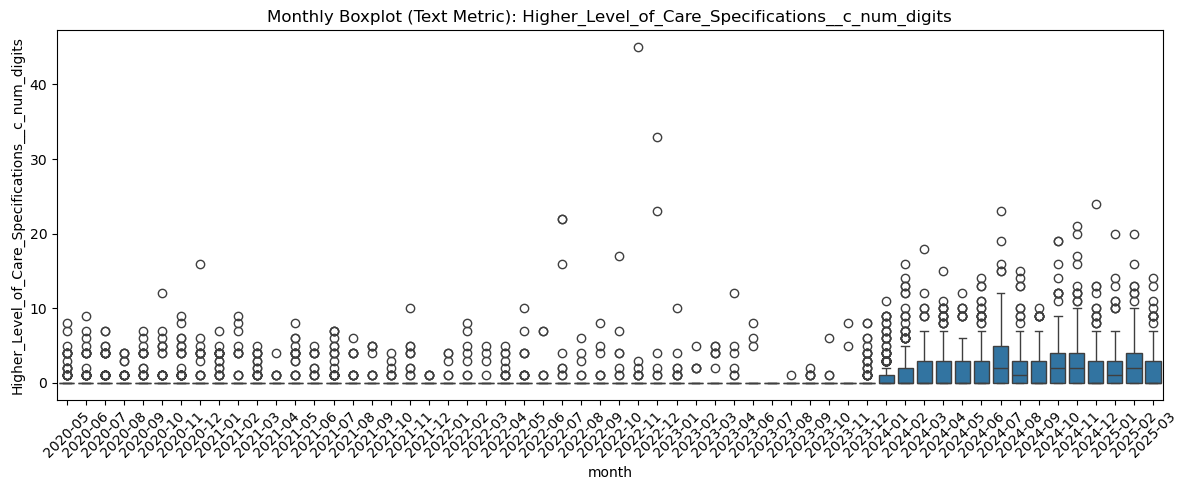

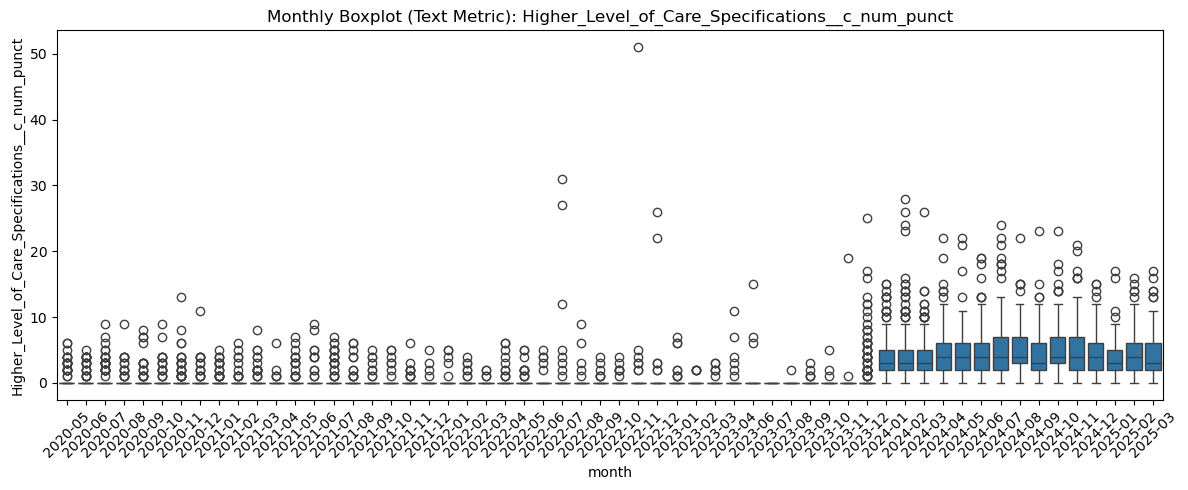

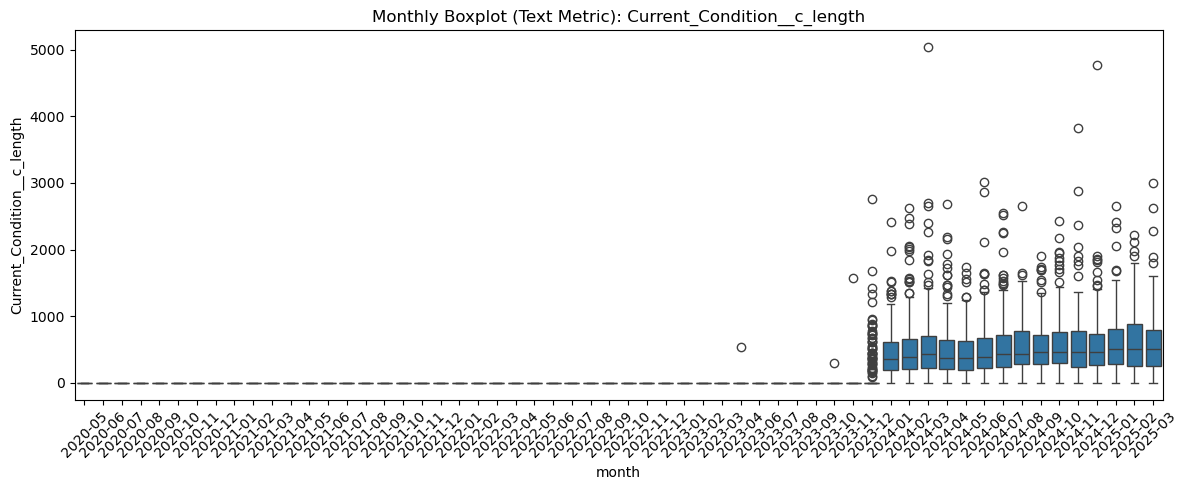

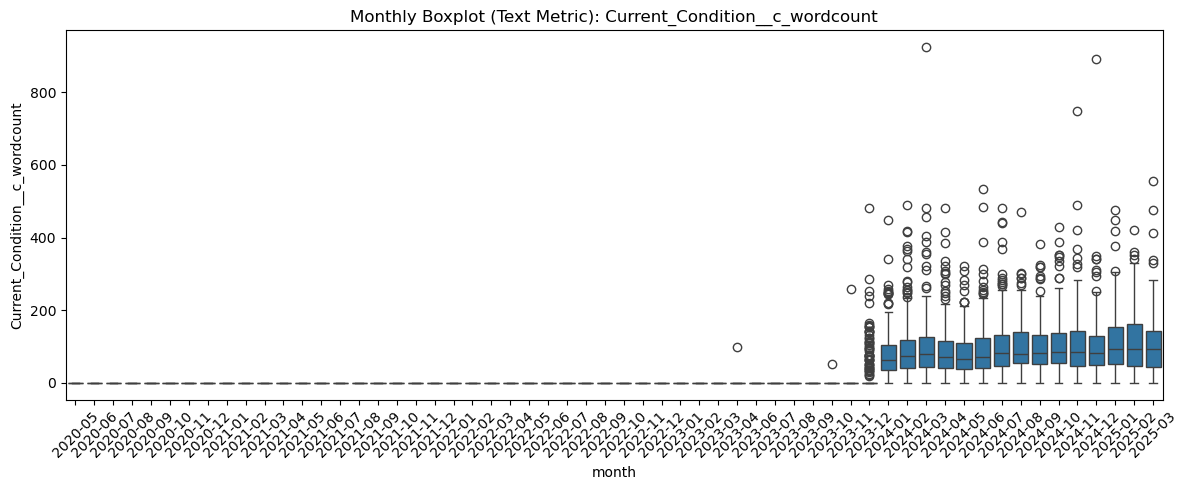

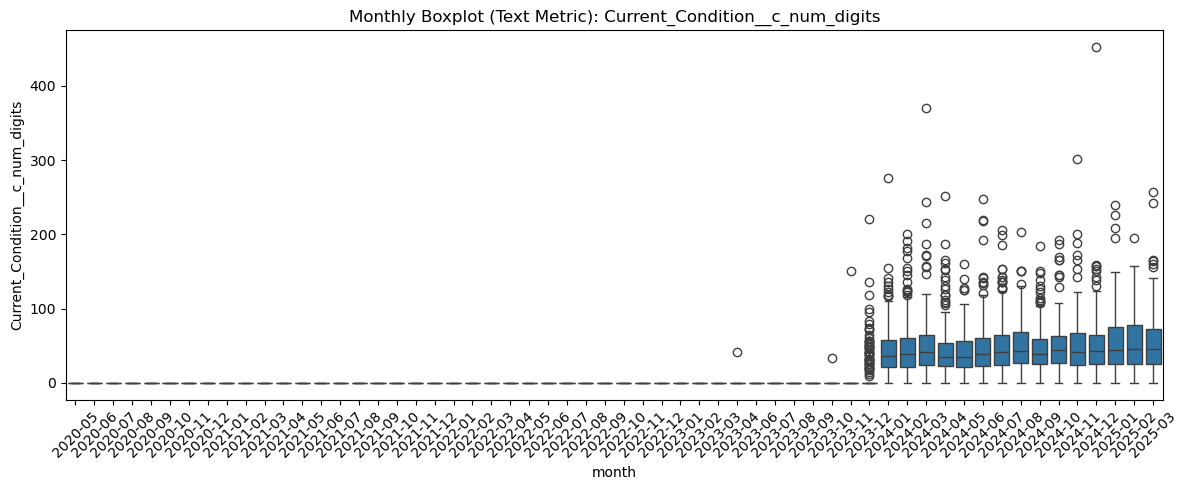

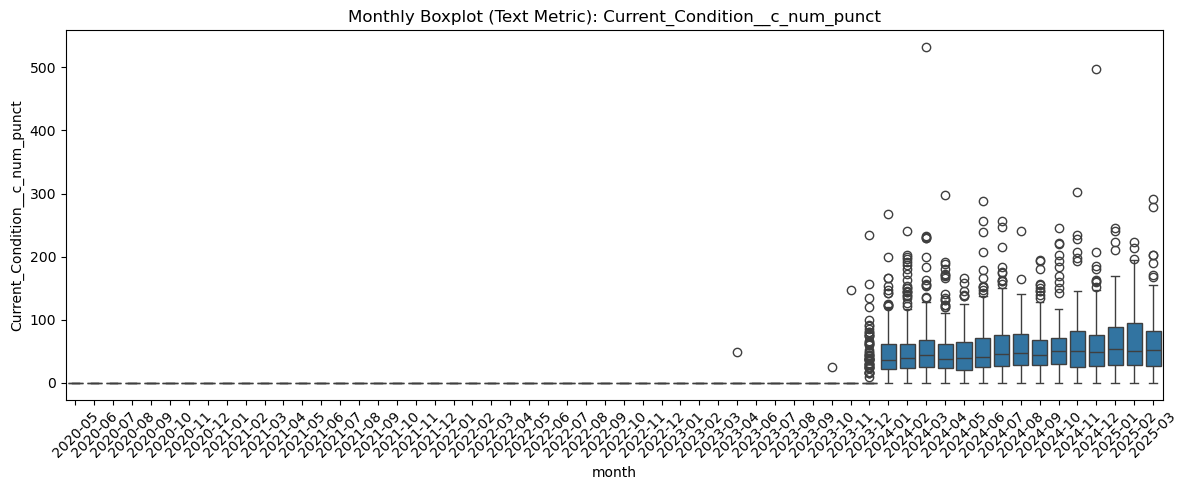

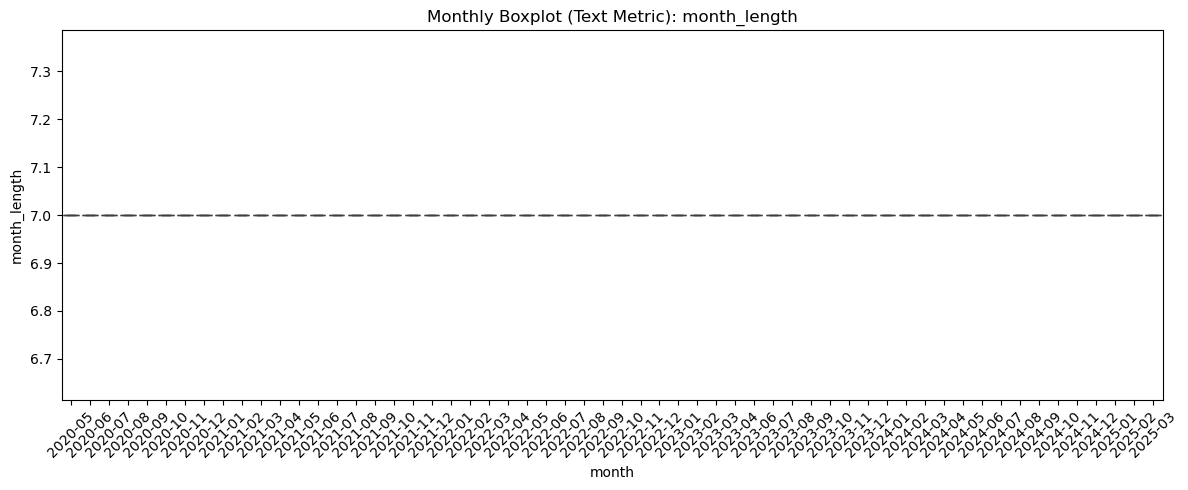

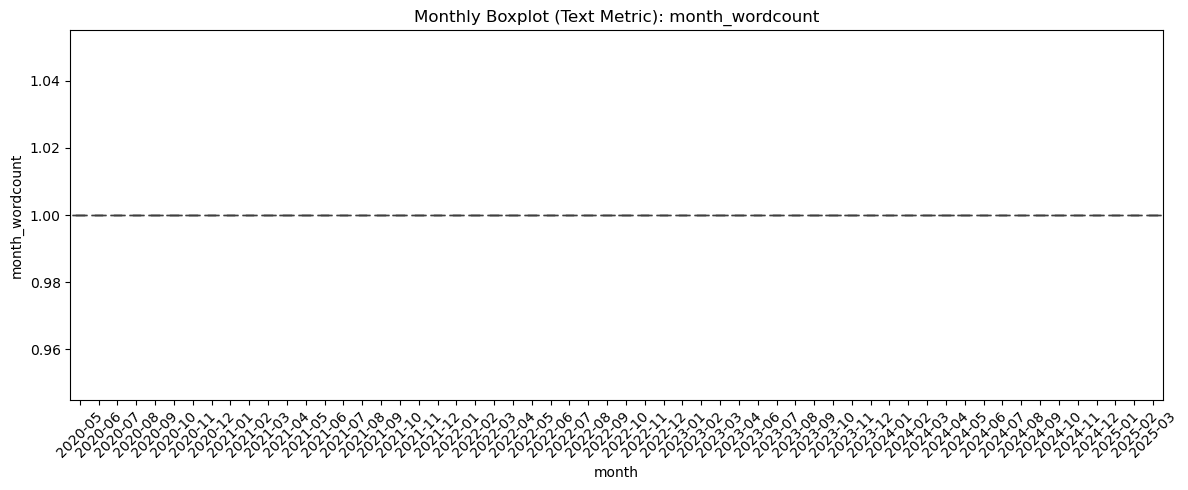

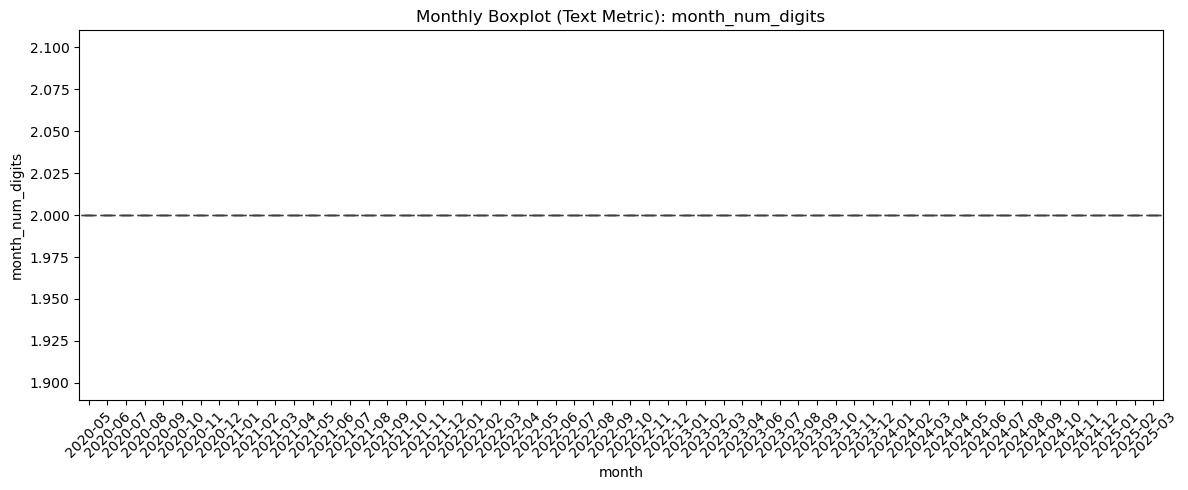

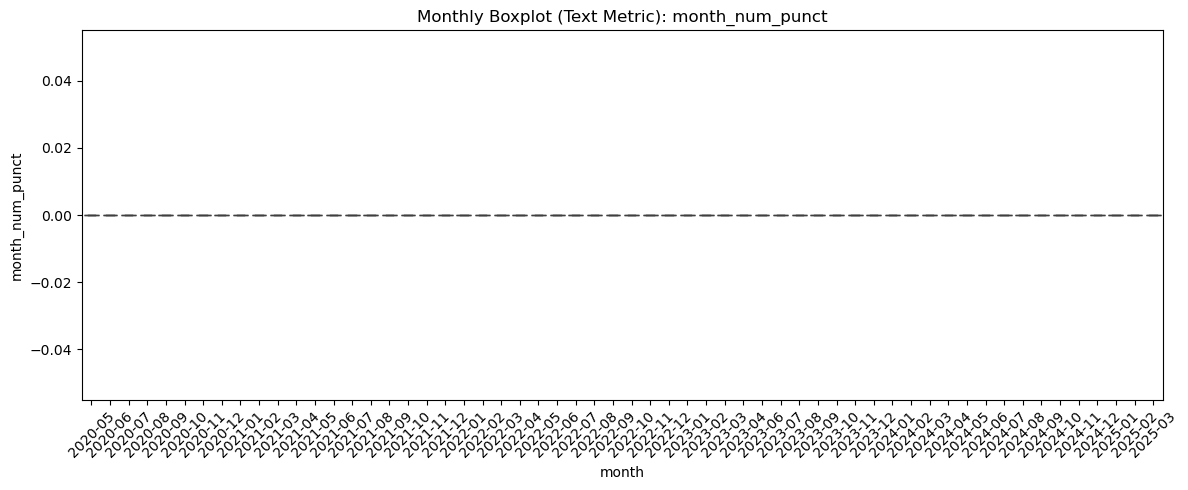

In [74]:
plot_features_monthly(df_cleaned_combined, time_col='admitdatetime')

## Outlier Drift Interpretation & Feature Shortlist

---

### Interpretation: 2020-trained model predicting 2021–2025
- Observation: Outlier ratio remains moderate (0.1–0.3) from 2021–2023 but spikes sharply from mid-2023, peaking in early 2024 (close to 1.0).
- Insight: The large 2024 spike likely corresponds to structural or categorical shifts in certain features (observed in boxplots and bar charts).
- Potential Contributors:
  - Categorical: `Patient_Prospect__c` (shift toward “Prospect”), `Smart_Transfer__c` (“Yes” rate increases), `Insurance_Type__c` (payer distribution shifts).
  - Text: `Current_Condition__c` and `Pertinent_History_Reason_Admitted__c` show increasing text length/variance in 2024.
  - Numeric: `Priority_Score__c` expands in range & variability.

---

### Shortlist of Features to Keep (High Drift Contribution)

#### Categorical Features (Large Distribution Shifts)
- `Patient_Prospect__c` — Category shift in 2024 toward “Prospect”
- `Smart_Transfer__c` — “Yes” category increase in 2024
- `Insurance_Type__c` — HMO/Medicare/MediCal distribution change post-2023
- `Resource_Intensive_Red_Flags__c` — Multiple subcategory distribution changes in mid–late 2024

#### Text Features (Length & Variability Changes)
- `Current_Condition__c` — Sharp increase in text length & variance from 2023
- `Pertinent_History_Reason_Admitted__c` — Noticeable increase in text content length & variability

#### Numeric Features (Gradual Change)
- `Priority_Score__c` — Expanding range and variability during 2024

---

### Features to Consider Dropping (Low Drift Contribution)
- `Transfer_Type__c` — Flat distribution
- `Required_Level_Of_Care__c` — Relatively stable after early 2023 shift
- `Patient_Status__c` — Distribution remains stable
- `Physician_Decision__c` — Minor fluctuation; mostly constant acceptance rate

In [11]:
# ✅ Define shortlist of features to keep (high drift contributors)
selected_features = [
    
    # Categorical
    'Patient_Prospect__c',
    'Smart_Transfer__c',
    'Insurance_Type__c',
    'Resource_Intensive_Red_Flags__c',

    # Text
    'Current_Condition__c',
    'Pertinent_History_Reason_Admitted__c',
    'Higher_Level_of_Care_Specifications__c',

    # Numeric
    'Priority_Score__c'

]

# ✅ Filter dataframe to only selected features + datetime column
df_selected = df_cleaned_combined[["admitdatetime"] + selected_features].copy()

print("Selected dataframe shape:", df_selected.shape)
print("Columns in selection:", df_selected.columns.tolist())

Selected dataframe shape: (9841, 9)
Columns in selection: ['admitdatetime', 'Patient_Prospect__c', 'Smart_Transfer__c', 'Insurance_Type__c', 'Resource_Intensive_Red_Flags__c', 'Current_Condition__c', 'Pertinent_History_Reason_Admitted__c', 'Higher_Level_of_Care_Specifications__c', 'Priority_Score__c']


# Outlier drift on selected data columns from intake form


=== Running Outlier Detection for split_date: 2021-01-01 ===

=== Running Outlier Detection for split_date: 2021-07-01 ===

=== Running Outlier Detection for split_date: 2022-01-01 ===

=== Running Outlier Detection for split_date: 2022-07-01 ===

=== Running Outlier Detection for split_date: 2023-01-01 ===

=== Running Outlier Detection for split_date: 2023-07-01 ===

=== Running Outlier Detection for split_date: 2024-01-01 ===

=== Running Outlier Detection for split_date: 2024-07-01 ===


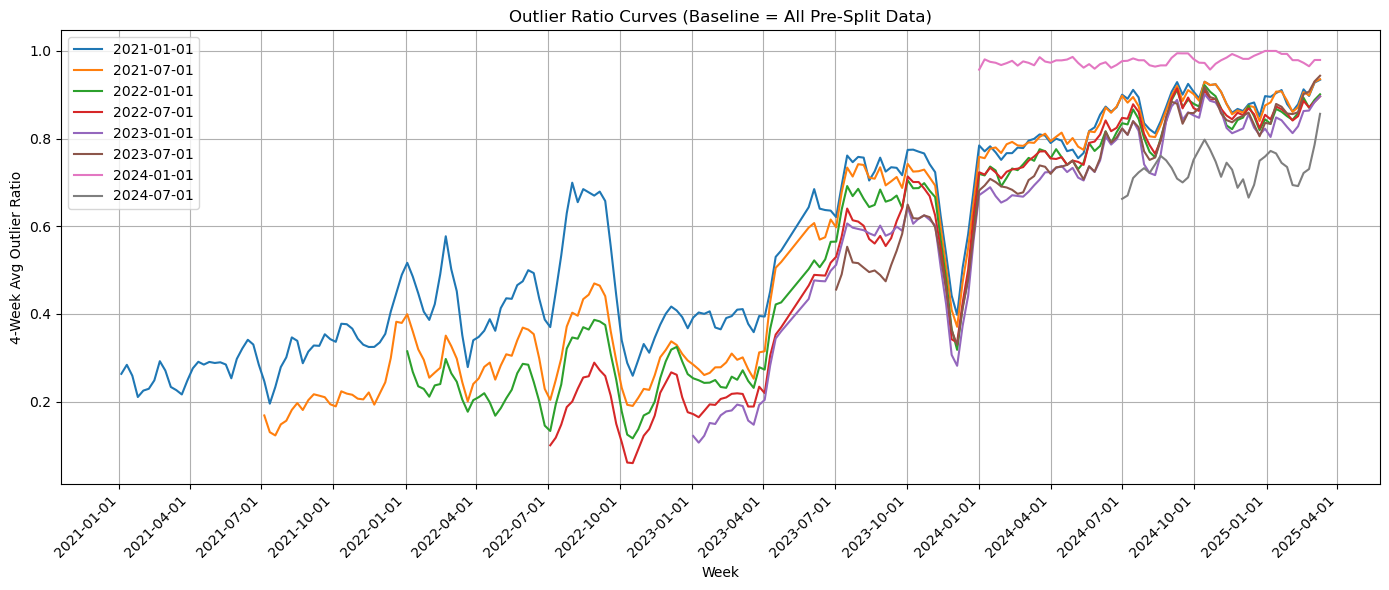


Outlier curves saved to outlier_curves_results_train_on_all_pre_split.csv


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from matplotlib.dates import MonthLocator, DateFormatter

def detect_outliers_fixed_training(df, split_date, time_col='admitdatetime', cat_thresh=50,
                                   rolling_window=4, smooth_window_months=3, contamination=0.1):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df[df[time_col].notna()].copy()
    df['week'] = df[time_col].dt.to_period('W').apply(lambda r: r.start_time)
    df['month'] = df[time_col].dt.to_period('M').apply(lambda r: r.start_time)

    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    text_cols = []
    categorical_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique(dropna=True) < cat_thresh:
            categorical_cols.append(col)
        else:
            text_cols.append(col)

    df = df.drop(columns=['outlier_flag'], errors='ignore')

    numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
    categorical_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        FunctionTransformer(lambda x: x.astype(str), validate=False),
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ], remainder='drop')

    X_structured = preprocessor.fit_transform(df[numeric_cols + categorical_cols])
    X_text = np.hstack([extract_text_features(df[col].fillna('')) for col in text_cols]) if text_cols else np.empty((len(df), 0))
    X_all = np.hstack([X_structured, X_text])

    df['outlier_flag'] = 0
    split_date = pd.to_datetime(split_date)

    # ✅ Baseline = all data before split_date (align with prediction training)
    train_idx = df[time_col] < split_date
    test_idx = df[time_col] >= split_date

    X_train = X_all[train_idx]
    X_test = X_all[test_idx]

    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X_train)

    preds = model.predict(X_test)
    df.loc[test_idx, 'outlier_flag'] = (preds == -1).astype(int)

    # Weekly stats and rolling 4-week ratio
    weekly_stats = df.groupby('week')['outlier_flag'].agg(['sum', 'count']).reset_index()
    weekly_stats['ratio'] = weekly_stats['sum'] / weekly_stats['count']

    rolling_data = []
    for i in range(len(weekly_stats) - rolling_window + 1):
        window_df = weekly_stats.iloc[i:i + rolling_window]
        avg_ratio = window_df['ratio'].mean()
        rolling_data.append({
            'start_week': window_df['week'].iloc[0],
            'end_week': window_df['week'].iloc[-1],
            '4wk_avg_ratio': avg_ratio
        })
    rolling_df = pd.DataFrame(rolling_data)

    return df, rolling_df


# -----------------------
# Loop for all split dates
# -----------------------
split_dates = pd.date_range("2020-12-31", "2024-12-31", freq="6MS")
all_outlier_curves = []

plt.figure(figsize=(14, 6))

for split_date in split_dates:
    print(f"\n=== Running Outlier Detection for split_date: {split_date.date()} ===")
    
    df_outliers, rolling_df = detect_outliers_fixed_training(
        df_selected,
        split_date=split_date,
        time_col='admitdatetime',
        smooth_window_months=3
    )
    
    rolling_df['split_date'] = split_date
    all_outlier_curves.append(rolling_df)
    
    # Only plot post-split
    rolling_df_after_split = rolling_df[rolling_df['start_week'] >= split_date]
    plt.plot(rolling_df_after_split['start_week'], rolling_df_after_split['4wk_avg_ratio'], label=f"{split_date.date()}")

# Quarterly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.xlabel("Week")
plt.ylabel("4-Week Avg Outlier Ratio")
plt.title("Outlier Ratio Curves (Baseline = All Pre-Split Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
all_outlier_df = pd.concat(all_outlier_curves, ignore_index=True)
all_outlier_df.to_csv("outlier_curves_results_train_on_all_pre_split.csv", index=False)
print("\nOutlier curves saved to outlier_curves_results_train_on_all_pre_split.csv")


### correlation analysis outlier VS auroc

In [13]:
# ============================================================
# Outlier Drift (4wk_avg_ratio) vs AUROC — Correlation Analysis
# Loops across tasks: mortality, los, readmit30
#
# Inputs searched under ./results:
#   1) Outlier curves (preferred per-task; fallback shared):
#      - results/{task}_outlier_curves_Train_on_all_pre_date.csv
#      - results/outlier_curves_results_Train_on_all_pre_date.csv
#         (must include: split_date, start_week, end_week, 4wk_avg_ratio)
#   2) Scored predictions (row-level):
#      - results/{task}_scored_predictions.csv
#         (columns: split_date, admitdatetime, y_true, y_pred)
#
# Outputs to ./results:
#   - {task}_outlierratio_auroc_correlations.csv
#   - outlierratio_correlations_all_tasks.csv (combined)
# ============================================================

import os, io
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError, ParserError
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr, spearmanr

# -------------------
# Config
# -------------------
RESULTS_DIR = "results"
TASKS = ["mortality", "los", "readmit30"]   # update if needed
TIME_FREQ = "W"                              # weekly periods for AUROC
MAX_LAG = 6                                  # compute correlations for lags ±6 weeks

# Preferred per-task file; fallback shared file:
OUTLIER_FILE_PER_TASK = "{task}_outlier_curves_Train_on_all_pre_date.csv"
OUTLIER_FILE_SHARED   = "outlier_curves_results_Train_on_all_pre_date.csv"

# -------------------
# Safe I/O helpers
# -------------------
def safe_read_csv(path, parse_dates=None):
    """Robust CSV reader: returns (df, ok)."""
    full = os.path.join(RESULTS_DIR, path)
    if not os.path.exists(full):
        return pd.DataFrame(), False
    try:
        if os.path.getsize(full) == 0:
            return pd.DataFrame(), False
    except OSError:
        pass
    try:
        df = pd.read_csv(full, parse_dates=parse_dates)
        return df, True
    except (EmptyDataError, ParserError):
        return pd.DataFrame(), False
    except UnicodeDecodeError:
        with open(full, "rb") as f:
            raw = f.read()
        try:
            df = pd.read_csv(io.StringIO(raw.decode("utf-8", errors="ignore")), parse_dates=parse_dates)
            return df, True
        except Exception:
            return pd.DataFrame(), False

def atomic_write_csv(df, path):
    """Write CSV atomically to avoid zero-byte partial files."""
    full = os.path.join(RESULTS_DIR, path)
    os.makedirs(os.path.dirname(full), exist_ok=True)
    tmp = full + ".tmp"
    df.to_csv(tmp, index=False)
    os.replace(tmp, full)

# -------------------
# AUROC (weekly) from scored predictions
# -------------------
def _add_period(df, date_col="admitdatetime", freq="W"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d["period"] = d[date_col].dt.to_period(freq).dt.start_time
    return d

def compute_weekly_auroc(scored_df,
                         date_col="admitdatetime",
                         split_col="split_date",
                         y_col="y_true",
                         p_col="y_pred",
                         freq="W"):
    """
    Returns: DataFrame[split_date, week, n_week, auroc]
    Skips weeks with single class (AUROC undefined).
    """
    need = {split_col, date_col, y_col, p_col}
    if scored_df.empty or not need.issubset(scored_df.columns):
        return pd.DataFrame(columns=["split_date","week","n_week","auroc"])

    df = _add_period(scored_df, date_col=date_col, freq=freq)
    rows = []
    for split, gsplit in df.groupby(split_col):
        for per, g in gsplit.groupby("period"):
            y = g[y_col].dropna().astype(int).to_numpy()
            p = g[p_col].dropna().astype(float).to_numpy()
            n = min(len(y), len(p))
            if n == 0 or len(np.unique(y[:n])) < 2:
                continue
            try:
                auc = float(roc_auc_score(y[:n], p[:n]))
            except Exception:
                continue
            rows.append({
                "split_date": str(split),
                "week": pd.to_datetime(per),
                "n_week": int(n),
                "auroc": auc
            })
    out = pd.DataFrame(rows, columns=["split_date","week","n_week","auroc"])
    return out.sort_values(["split_date","week"]).reset_index(drop=True)

# -------------------
# Correlation helpers
# -------------------
def _corr_pair(x, y):
    x = pd.Series(x).astype(float)
    y = pd.Series(y).astype(float)
    mask = x.notna() & y.notna()
    x = x[mask]; y = y[mask]
    n = int(len(x))
    if n < 3:
        return None, None, n
    try:
        pr = pearsonr(x, y)[0]
    except Exception:
        pr = None
    try:
        sr = spearmanr(x, y, nan_policy="omit").correlation
    except Exception:
        sr = None
    return (float(pr) if pr is not None and np.isfinite(pr) else None,
            float(sr) if sr is not None and np.isfinite(sr) else None,
            n)

def correlate_outlierratio_with_auroc(outlier_df, auroc_df, max_lag=6):
    """
    Aligns by split_date and week (using outlier start_week == auroc week).
    Expects outlier_df columns: split_date, start_week, 4wk_avg_ratio
    Returns long DataFrame: split_date, lag_weeks, pearson, spearman, n_pairs
    """
    need_o = {"split_date","start_week","4wk_avg_ratio"}
    need_a = {"split_date","week","auroc"}
    if outlier_df.empty or not need_o.issubset(outlier_df.columns):
        return pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
    if auroc_df.empty or not need_a.issubset(auroc_df.columns):
        return pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])

    o = outlier_df.copy()
    a = auroc_df.copy()
    o["split_date"] = o["split_date"].astype(str)
    a["split_date"] = a["split_date"].astype(str)
    o["start_week"] = pd.to_datetime(o["start_week"], errors="coerce")
    a["week"]       = pd.to_datetime(a["week"], errors="coerce")

    rows = []
    for split in sorted(set(o["split_date"]).intersection(set(a["split_date"]))):
        do = o[o["split_date"] == split].copy()
        da = a[a["split_date"] == split].copy()

        # Keep only post-split outlier windows if your curves included pre-split rows
        # (Your training code already produces post-split only, but this is harmless.)
        # do = do[do["start_week"] >= pd.Timestamp(split)]

        base = pd.merge(
            do[["start_week","4wk_avg_ratio"]],
            da[["week","auroc"]].rename(columns={"week":"start_week"}),
            on="start_week",
            how="inner"
        ).sort_values("start_week")

        if base.empty:
            continue

        # Static (lag 0)
        pr, sr, n = _corr_pair(base["4wk_avg_ratio"], base["auroc"])
        rows.append({"split_date": split, "lag_weeks": 0, "pearson": pr, "spearman": sr, "n_pairs": n})

        # Lagged: positive lag => outlier drift leads AUROC
        for lag in range(1, max_lag + 1):
            lead = base.copy()
            lead["auroc_shifted"] = lead["auroc"].shift(-lag)  # AUROC future vs current outlier ratio
            pr, sr, n = _corr_pair(lead["4wk_avg_ratio"], lead["auroc_shifted"])
            rows.append({"split_date": split, "lag_weeks": +lag, "pearson": pr, "spearman": sr, "n_pairs": n})

            lagg = base.copy()
            lagg["auroc_shifted"] = lagg["auroc"].shift(+lag)  # AUROC past vs current outlier ratio
            pr, sr, n = _corr_pair(lagg["4wk_avg_ratio"], lagg["auroc_shifted"])
            rows.append({"split_date": split, "lag_weeks": -lag, "pearson": pr, "spearman": sr, "n_pairs": n})

    return pd.DataFrame(rows, columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])\
             .sort_values(["split_date","lag_weeks"]).reset_index(drop=True)

# -------------------
# Driver
# -------------------
def main():
    combined = []

    for task in TASKS:
        print(f"\n==== {task.upper()} ====")

        # ---- load outlier curves (per-task preferred; fallback shared) ----
        per_task_name = OUTLIER_FILE_PER_TASK.format(task=task)
        outlier_df, ok = safe_read_csv(per_task_name, parse_dates=["start_week","end_week"])
        if not ok or outlier_df.empty:
            shared_df, ok_shared = safe_read_csv(OUTLIER_FILE_SHARED, parse_dates=["start_week","end_week"])
            if ok_shared and not shared_df.empty:
                outlier_df = shared_df.copy()
                # If the shared file lacks task labels, we still proceed (we’re in a loop per task).
                # Optionally attach the task label so downstream combined output shows it.
                outlier_df["__source_task__"] = task
                print(f"[INFO] Using shared outlier file for {task}: {OUTLIER_FILE_SHARED}")
            else:
                print(f"[WARN] No outlier curves found for {task}. Skipping.")
                # Write an empty-but-structured CSV so pipeline doesn’t break
                empty = pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
                empty.insert(0, "task", task)
                atomic_write_csv(empty, f"{task}_outlierratio_auroc_correlations.csv")
                continue

        # ---- load scored predictions & compute weekly AUROC ----
        scored_path = f"{task}_scored_predictions.csv"
        scored_df, ok_scored = safe_read_csv(scored_path, parse_dates=["admitdatetime"])
        if not ok_scored or scored_df.empty:
            print(f"[WARN] Missing/empty scored predictions for {task}. Skipping.")
            empty = pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
            empty.insert(0, "task", task)
            atomic_write_csv(empty, f"{task}_outlierratio_auroc_correlations.csv")
            continue

        auroc_df = compute_weekly_auroc(
            scored_df,
            date_col="admitdatetime",
            split_col="split_date",
            y_col="y_true",
            p_col="y_pred",
            freq=TIME_FREQ
        )

        if auroc_df.empty:
            print(f"[WARN] AUROC weekly is empty for {task} (single-class periods or no rows). Skipping.")
            empty = pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
            empty.insert(0, "task", task)
            atomic_write_csv(empty, f"{task}_outlierratio_auroc_correlations.csv")
            continue

        # ---- normalize essential columns ----
        # Expect: outlier_df has split_date, start_week, end_week, 4wk_avg_ratio
        # If your columns differ, adapt here.
        if "split_date" not in outlier_df.columns:
            # If you trained across a sequence of split_dates, ensure this exists;
            # If not, attach a default or infer.
            print(f"[WARN] Outlier curves missing 'split_date' — correlations may be incomplete.")
            outlier_df["split_date"] = scored_df["split_date"].astype(str).mode().iloc[0] if "split_date" in scored_df.columns else "UNKNOWN"

        need_cols = {"split_date","start_week","4wk_avg_ratio"}
        missing = need_cols - set(outlier_df.columns)
        if missing:
            print(f"[WARN] Outlier curves for {task} missing columns: {missing}. Skipping.")
            empty = pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
            empty.insert(0, "task", task)
            atomic_write_csv(empty, f"{task}_outlierratio_auroc_correlations.csv")
            continue

        # ---- correlate per split_date (lag 0 and ±MAX_LAG) ----
        corr_df = correlate_outlierratio_with_auroc(outlier_df, auroc_df, max_lag=MAX_LAG)

        # Save per-task results (always write headers)
        corr_df = corr_df if not corr_df.empty else pd.DataFrame(columns=["split_date","lag_weeks","pearson","spearman","n_pairs"])
        corr_df.insert(0, "task", task)
        out_task = f"{task}_outlierratio_auroc_correlations.csv"
        atomic_write_csv(corr_df, out_task)
        print(f"[OK] Saved → {os.path.join(RESULTS_DIR, out_task)} (rows={len(corr_df)})")

        combined.append(corr_df)

        # Quick console preview (static lag=0)
        if not corr_df.empty:
            static = corr_df[corr_df["lag_weeks"] == 0]
            if not static.empty:
                print("\n-- Static (lag=0) correlations --")
                print(static[["split_date","pearson","spearman","n_pairs"]].to_string(index=False))

    # ---- combined file across tasks ----
    if combined:
        all_df = pd.concat(combined, ignore_index=True)
        out_all = "outlierratio_correlations_all_tasks.csv"
        atomic_write_csv(all_df, out_all)
        print(f"\n[OK] Saved combined correlations → {os.path.join(RESULTS_DIR, out_all)} (rows={len(all_df)})")

    print("\n[DONE] Outlier vs AUROC correlation analysis complete.")
    print("If you see empty outputs, check:")
    print("  • Outlier curves have split_date/start_week/4wk_avg_ratio")
    print("  • Scored predictions contain split_date/admitdatetime/y_true/y_pred")
    print("  • Weeks overlap (both sides use weekly START times).")
    print("  • AUROC weeks have both classes present.")

if __name__ == "__main__":
    main()





==== MORTALITY ====
[INFO] Using shared outlier file for mortality: outlier_curves_results_Train_on_all_pre_date.csv
[OK] Saved → results/mortality_outlierratio_auroc_correlations.csv (rows=91)

-- Static (lag=0) correlations --
split_date   pearson  spearman  n_pairs
2021-01-01  0.137649  0.102484      198
2021-07-01  0.109167  0.093370      173
2022-01-01  0.209504  0.225554      149
2022-07-01  0.171321  0.199425      123
2023-01-01  0.055365  0.084117       96
2023-07-01  0.172881  0.152059       76
2024-01-01 -0.087614 -0.097155       49

==== LOS ====
[INFO] Using shared outlier file for los: outlier_curves_results_Train_on_all_pre_date.csv
[OK] Saved → results/los_outlierratio_auroc_correlations.csv (rows=91)

-- Static (lag=0) correlations --
split_date   pearson  spearman  n_pairs
2021-01-01 -0.072620 -0.069424      202
2021-07-01 -0.044027 -0.050012      176
2022-01-01  0.023046  0.032177      150
2022-07-01  0.034907  0.022622      124
2023-01-01  0.070600  0.127131       9

# Data drift

In [15]:
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import os

def detect_data_drift_across_splits_selected(
    df,
    split_dates,
    selected_features,
    time_col='admitdatetime',
    output_csv='results/data_drift_summary.csv'
):
    """
    Runs data drift detection using selected features only:
    - Trains on all data before each split_date
    - Computes drift (numeric KS, categorical chi2 p, text JS) in 4-week rolling windows after split_date

    Saves output CSV, no plotting.
    """
    all_results = []

    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df[df[time_col].notna()].copy()

    # Create 'week' column BEFORE subsetting
    df['week'] = df[time_col].dt.to_period('W')

    # Subset only selected features + time_col + week
    df = df[[time_col, 'week'] + selected_features].copy()

    # Manually define feature types
    numeric_cols = ['Priority_Score__c']
    categorical_cols = [
        'Patient_Prospect__c',
        'Smart_Transfer__c',
        'Insurance_Type__c',
        'Resource_Intensive_Red_Flags__c',
    ]
    text_cols = [
        'Current_Condition__c',
        'Pertinent_History_Reason_Admitted__c',
    ]

    # Combine text columns
    df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
    df = df[df['combined_text'].str.strip() != '']

    for split_date in split_dates:
        split_date = pd.to_datetime(split_date)
        print(f"[INFO] Processing split_date: {split_date.date()}")

        # Baseline: all data before split_date
        baseline_df = df[df[time_col] < split_date]
        if baseline_df.empty or baseline_df['combined_text'].dropna().empty:
            print(f"  [Warning] Empty or invalid baseline for {split_date} — skipping.")
            continue

        tfidf = TfidfVectorizer(max_features=100)
        tfidf.fit(baseline_df['combined_text'])
        base_vec = tfidf.transform(baseline_df['combined_text']).mean(axis=0).A1

        # Post-split data
        post_df = df[df[time_col] >= split_date].copy()
        post_df_weeks = sorted(post_df['week'].unique())

        for i in range(len(post_df_weeks) - 3):
            window_weeks = post_df_weeks[i:i + 4]
            current_df = post_df[post_df['week'].isin(window_weeks)]

            drift_metrics = {
                'split_date': split_date.date(),
                'start_week': window_weeks[0].start_time.date(),
                'end_week': window_weeks[-1].end_time.date()
            }

            # ---- Numeric Drift ----
            ks_vals = []
            for col in numeric_cols:
                try:
                    base_vals = baseline_df[col].dropna()
                    curr_vals = current_df[col].dropna()
                    if len(base_vals) > 0 and len(curr_vals) > 0:
                        stat, _ = ks_2samp(base_vals, curr_vals)
                        ks_vals.append(stat)
                    else:
                        ks_vals.append(np.nan)
                except:
                    ks_vals.append(np.nan)
            drift_metrics['avg_numeric_ks'] = np.nanmean(ks_vals)

            # ---- Categorical Drift ----
            chi_vals = []
            for col in categorical_cols:
                try:
                    freq_base = baseline_df[col].dropna().value_counts(normalize=True)
                    freq_curr = current_df[col].dropna().value_counts(normalize=True)
                    common_idx = freq_base.index.intersection(freq_curr.index)
                    if len(common_idx) > 1:
                        obs = pd.DataFrame({'base': freq_base[common_idx], 'curr': freq_curr[common_idx]})
                        chi2, p, _, _ = chi2_contingency(obs.T)
                        chi_vals.append(p)
                    else:
                        chi_vals.append(np.nan)
                except:
                    chi_vals.append(np.nan)
            drift_metrics['avg_categorical_chi2p'] = np.nanmean(chi_vals)

            # ---- Text Drift ----
            try:
                curr_vec = tfidf.transform(current_df['combined_text']).mean(axis=0).A1
                js_div = jensenshannon(base_vec, curr_vec)
            except:
                js_div = np.nan
            drift_metrics['text_js_divergence'] = js_div

            all_results.append(drift_metrics)

    # Save results
    result_df = pd.DataFrame(all_results)
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    result_df.to_csv(output_csv, index=False)
    print(f"[INFO] Drift results saved to {output_csv}")

    return result_df





In [16]:
selected_features = [
    'Patient_Prospect__c',
    'Smart_Transfer__c',
    'Insurance_Type__c',
    'Resource_Intensive_Red_Flags__c',
    'Current_Condition__c',
    'Pertinent_History_Reason_Admitted__c',
    'Priority_Score__c'
]

split_dates = [
    "2020-01-01",
    "2020-07-01",
    "2021-01-01",
    "2021-07-01",
    "2022-01-01",
    "2022-07-01",
    "2023-01-01",
    "2023-07-01",
    "2024-01-01",
    "2024-07-01",
    "2025-01-01"
]



drift_df = detect_data_drift_across_splits_selected(
    df=df_selected,
    split_dates=split_dates,
    selected_features=selected_features,
    output_csv='results/data_drift_summary.csv'
)

[INFO] Processing split_date: 2020-01-01
  [Warning] Empty or invalid baseline for 2020-01-01 00:00:00 — skipping.
[INFO] Processing split_date: 2020-07-01
[INFO] Processing split_date: 2021-01-01
[INFO] Processing split_date: 2021-07-01
[INFO] Processing split_date: 2022-01-01
[INFO] Processing split_date: 2022-07-01
[INFO] Processing split_date: 2023-01-01
[INFO] Processing split_date: 2023-07-01
[INFO] Processing split_date: 2024-01-01
[INFO] Processing split_date: 2024-07-01
[INFO] Processing split_date: 2025-01-01
[INFO] Drift results saved to results/data_drift_summary.csv


In [17]:
def check_baseline_completeness(df_selected, split_dates):
    import pandas as pd

    # ---- Define your feature types (same as in drift detection)
    numeric_cols = ['Priority_Score__c']
    categorical_cols = [
        'Patient_Prospect__c',
        'Smart_Transfer__c',
        'Insurance_Type__c',
        'Resource_Intensive_Red_Flags__c',
    ]
    text_cols = [
        'Current_Condition__c',
        'Pertinent_History_Reason_Admitted__c',
    ]

    # ---- Parse datetime and prepare
    df = df_selected.copy()
    df['admitdatetime'] = pd.to_datetime(df['admitdatetime'], errors='coerce')
    df = df[df['admitdatetime'].notna()]

    # ---- Combine text
    df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
    df['text_valid'] = df['combined_text'].str.strip() != ''

    results = []

    for split in split_dates:
        split_date = pd.to_datetime(split)
        baseline = df[df['admitdatetime'] < split_date]

        result = {
            'split_date': split,
            'baseline_rows': len(baseline),
            'numeric_valid_ratio': baseline[numeric_cols].notna().mean().mean() if not baseline.empty else 0,
            'categorical_valid_ratio': baseline[categorical_cols].notna().mean().mean() if not baseline.empty else 0,
            'text_valid_ratio': baseline['text_valid'].mean() if not baseline.empty else 0
        }

        results.append(result)

    return pd.DataFrame(results)

split_dates = [
    "2020-07-01", "2021-01-01", "2021-07-01", "2022-01-01",
    "2022-07-01", "2023-01-01", "2023-07-01", "2024-01-01",
    "2024-07-01", "2025-01-01"
]

baseline_check = check_baseline_completeness(df_selected, split_dates)
baseline_check

,split_date,baseline_rows,numeric_valid_ratio,categorical_valid_ratio,text_valid_ratio
0,2020-07-01,250,0.000000,0.248000,0.980000
1,2021-01-01,1096,0.000000,0.249088,0.989051
2,2021-07-01,2099,0.000000,0.361839,0.992854
3,2022-01-01,3098,0.000000,0.402679,0.994835
4,2022-07-01,4009,0.000000,0.422425,0.995510
5,2023-01-01,5025,0.000000,0.436169,0.996219
6,2023-07-01,5899,0.000170,0.443084,0.996271
7,2024-01-01,7079,0.005933,0.452041,0.996468
8,2024-07-01,8360,0.122847,0.454994,0.995813
9,2025-01-01,9429,0.199491,0.477198,0.995864


In [16]:
# Intake features to check
selected_features = [
    'Patient_Prospect__c',
    'Smart_Transfer__c',
    'Insurance_Type__c',
    'Resource_Intensive_Red_Flags__c',
    'Current_Condition__c',
    'Pertinent_History_Reason_Admitted__c',
    'Priority_Score__c',
    'Higher_Level_of_Care_Specifications__c'
]

# Check missingness and uniqueness
empty_cols = []
print("🔍 Feature Check on df_selected:\n")
for col in selected_features:
    missing_ratio = df_selected[col].isna().mean()
    unique_vals = df_selected[col].dropna().unique()
    print(f"{col:42} | Missing: {missing_ratio:.1%} | Unique non-null values: {len(unique_vals)}")
    if len(unique_vals) == 0:
        empty_cols.append(col)

# Final summary
if empty_cols:
    print("\n❌ Completely missing in df_selected:")
    for col in empty_cols:
        print(f" - {col}")
else:
    print("\n✅ All selected features contain data.")


🔍 Feature Check on df_selected:

Patient_Prospect__c                        | Missing: 13.5% | Unique non-null values: 4
Smart_Transfer__c                          | Missing: 89.0% | Unique non-null values: 2
Insurance_Type__c                          | Missing: 4.0% | Unique non-null values: 9
Resource_Intensive_Red_Flags__c            | Missing: 98.8% | Unique non-null values: 18
Current_Condition__c                       | Missing: 72.4% | Unique non-null values: 2711
Pertinent_History_Reason_Admitted__c       | Missing: 0.5% | Unique non-null values: 9743
Priority_Score__c                          | Missing: 77.4% | Unique non-null values: 11
Higher_Level_of_Care_Specifications__c     | Missing: 67.2% | Unique non-null values: 3182

✅ All selected features contain data.


# Feature drift PCA

In [21]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import os

def detect_feature_drift_across_splits(
    df,
    split_dates,
    time_col='admitdatetime',
    cat_thresh=50,
    output_csv='results/feature_drift_summary.csv'
):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df[df[time_col].notna()]
    df['week'] = df[time_col].dt.to_period('W')

    # Auto classify
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    text_cols = []
    categorical_cols = []
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique(dropna=True) < cat_thresh:
            categorical_cols.append(col)
        else:
            text_cols.append(col)

    # Preprocessing
    numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
    for col in categorical_cols:
        df[col] = df[col].astype(str).fillna("missing")
    categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False))

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ], remainder='drop')
    X_structured = preprocessor.fit_transform(df)

    def extract_text_features(texts):
        features = []
        for text in texts:
            if not isinstance(text, str):
                text = ''
            text_features = [
                len(text),
                len(text.split()),
                len(text.split('\n')),
                len(re.findall(r'\d+', text)),
                len(re.findall(r'[A-Z]', text)),
                len(re.findall(r'[a-z]', text)),
                len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', text)),
                text.count('.'),
                text.count(','),
                text.count(';'),
                text.count(':'),
                text.count('('),
                text.count(')'),
                text.count('['),
                text.count(']'),
                text.count('{'),
                text.count('}'),
                text.count('"'),
                text.count("'"),
            ]
            features.append(text_features)
        return np.array(features)

    X_text = (
        np.hstack([extract_text_features(df[col].fillna('')) for col in text_cols])
        if text_cols else np.empty((len(df), 0))
    )

    all_features = np.hstack([X_structured, X_text])
    df['features'] = list(all_features)

    all_results = []

    for split_date in split_dates:
        split_date = pd.to_datetime(split_date)
        print(f"[INFO] Processing split_date: {split_date.date()}")

        # Baseline = all data before split
        baseline_df = df[df[time_col] < split_date].copy()
        if baseline_df.empty:
            print(f"  [Warning] Empty baseline for {split_date} — skipping.")
            continue

        baseline_data = np.stack(baseline_df['features'].values)

        # Post-split data
        post_df = df[df[time_col] >= split_date].copy()
        post_df_weeks = sorted(post_df['week'].unique())

        for i in range(len(post_df_weeks) - 3):
            window_weeks = post_df_weeks[i:i + 12]
            current_df = post_df[post_df['week'].isin(window_weeks)]
            if current_df.empty:
                continue
            current_data = np.stack(current_df['features'].values)

            # PCA on baseline
            n_components = min(10, baseline_data.shape[1], current_data.shape[1])
            pca = PCA(n_components=n_components)
            baseline_pca = pca.fit_transform(baseline_data)
            current_pca = pca.transform(current_data)

            ks_vals, js_vals = [], []
            for j in range(n_components):
                base_pc = baseline_pca[:, j]
                curr_pc = current_pca[:, j]
                ks_stat, _ = ks_2samp(base_pc, curr_pc)
                hist_base, _ = np.histogram(base_pc, bins=50, density=True)
                hist_curr, _ = np.histogram(curr_pc, bins=50, density=True)
                if np.sum(hist_base) > 0 and np.sum(hist_curr) > 0:
                    js = jensenshannon(hist_base, hist_curr)
                    js = 0.0 if np.isnan(js) else js
                else:
                    js = 0.0
                ks_vals.append(ks_stat)
                js_vals.append(js)

            all_results.append({
                'split_date': split_date.date(),
                'start_week': window_weeks[0].start_time.date(),
                'end_week': window_weeks[-1].end_time.date(),
                'avg_pca_ks': np.mean(ks_vals),
                'avg_pca_js': np.mean(js_vals)
            })

    results_df = pd.DataFrame(all_results)
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    results_df.to_csv(output_csv, index=False)
    print(f"[INFO] Feature drift results saved to {output_csv}")

    return results_df

In [22]:
split_dates = [
    "2020-07-01", "2021-01-01", "2021-07-01", "2022-01-01",
    "2022-07-01", "2023-01-01", "2023-07-01", "2024-01-01",
    "2024-07-01"
]

df_selected['week'] = pd.to_datetime(df_selected['admitdatetime']).dt.to_period('W')

feature_drift_df = detect_feature_drift_across_splits(
    df=df_selected,
    split_dates=split_dates,
    output_csv='results/feature_drift_summary.csv'
)

[INFO] Processing split_date: 2020-07-01
[INFO] Processing split_date: 2021-01-01
[INFO] Processing split_date: 2021-07-01
[INFO] Processing split_date: 2022-01-01
[INFO] Processing split_date: 2022-07-01
[INFO] Processing split_date: 2023-01-01
[INFO] Processing split_date: 2023-07-01
[INFO] Processing split_date: 2024-01-01
[INFO] Processing split_date: 2024-07-01
[INFO] Feature drift results saved to results/feature_drift_summary.csv
